![banner](./images/knobs.jpeg)

# *Live DJ Assist: Using Spotify to Build a Recommendation System for DJ'ing Electronic Dance Music*
***
Author: [Paul Lindquist](https://www.linkedin.com/in/paul-lindquist/)

## Table of Contents <a name="toc"></a>
***
1. [Background](#background)
2. [Overview](#overview)
3. [Business Objective](#objective)
4. [Data](#data)
5. [Methods](#methods)
6. [Library Imports](#imports)
7. [API Calls](#api)
8. [Data Imports, Creation, Concatenation and Cleaning](#datacleaning)
9. [Exploratory Data Analysis (EDA)](#eda)
10. [Modeling (Genres Included)](#modelinggenres)
11. [Modeling (No Genres)](#modelingnogenres)
12. [Final Model Function](#finalmodel)
13. [Results](#results)
14. [Conclusions](#conclusions)
15. [Limitations](#limitations)
16. [Next Steps](#nextsteps)

## Background <a name="background"></a>
***
Electronic dance music is overwhelmingly created with computers and plugins rather than instruments and live recordings. It's typically distributed digitally, opting for high-quality .wav, .aiff and .mp3 files over CDs and vinyl. As such, thousands of new songs are released every day. This presents a challenge for any DJ or music curator seeking to keep their library current without drowning in new releases. To complicate matters further, the music isn't centralized. Releases are sold on numerous online stores like [Beatport](https://www.beatport.com/), [Juno Download](https://www.junodownload.com/), [Traxsource](https://www.traxsource.com/) and [Bandcamp](https://bandcamp.com/) or given away for free on platforms like [Soundcloud](https://soundcloud.com/). Crate digging has long since moved to the digital space and it's easy to get overwhelmed.

Like any other genre of music, electronic dance music has historically been categorized by sub-genres. Generally, those sub-genres are defined by features like tempo (beats per minute/BPM), mood and the types of instrument samples used. Trance rarely dips below 122 beats per minute, saw synths aren't heavily utilized in Deep House, etc. But as the music has evolved and artists implement elements from different sub-genres, classifying songs by sub-genre has become both cumbersome and antiquated. There needs to be a more efficient way to analyze songs irrespective of sub-genres. By the early 2010s, a leader emerged in that space.

Spotify acquired that leader, music intelligence and data platform *The Echo Nest*, in 2014. Shortly thereafter, they began integrating *TEN*'s algorithm-based audio analysis and tagging songs with audio features such as valence, energy, danceability, etc. Through their [Web API](https://developer.spotify.com/documentation/web-api/), Spotify permits the extraction of these features when building out datasets. Along with the additionally tagged sub-genres, this allows for a more detailed categorization and comparison of songs.

## Overview <a name="overview"></a>
***
This project leverages those audio features and focuses solely on electronic dance music within Spotify's database. Common sub-genres categorized by both [Every Noise at Once](https://everynoise.com/) and Spotify's own [genre seeds](https://developer.spotify.com/console/get-available-genre-seeds/) are used to narrow the final dataset.

Spotify is chosen as the singular data-gathering platform for a few reasons:
1. It's the world's most popular music streaming service with a database of over 70 million songs
2. The algorithm-based audio analysis (song features) provides unmatched opportunity for song comparison and recommendation
3. Their [Web API](https://developer.spotify.com/documentation/web-api/) is accessible and well-documented
4. Songs are tagged with identifiers like ID and URI for organized tracking

The following Spotify audio features are extracted and used in determining similarity for recommendation. Refer to the [documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) for an in-depth explanation of each:
- Acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo (BPM), valence

Musical features like key and mode are purposefully omitted because there are separate third-party applications (e.g. [Mixed in Key](https://mixedinkey.com/)) that can hard-tag songs with that information. Many DJs do this and will already have it available during song selection. Also, and perhaps more importantly, making recommendations based on a song's key can lead to a string of songs that sound too familiar. Over time, this creates a tired listening experience.

## Business Objective <a name="objective"></a>
***
This project sets out to make a recommendation system for electronic dance music, specifically with live DJ'ing in mind. It can assist DJs with tracklist preparation or live DJ performance. Often only 1 song is needed to fill out a set, create a bridge between 2 songs or inspire a line of thinking that allows the DJ to come up with the next song on their own. This recommendation system can assist that process.

Sometimes a DJ wants variety and would like to play a song that's categorized by a different sub-genre than the song currently being played. The final model function gives the option to provide recommendations within the same sub-genre or across all sub-genres.

I serve as my own stakeholder for this project. Personal domain knowledge is used to determine validity of the recommendations. I've DJ'ed electronic dance music for 13 years and have played countless live mixes. From 2013-2019, I co-founded, operated and resident DJ'ed an [electronic music podcast](https://podcasts.apple.com/us/podcast/electric-retox-electronic-music-podcast/id733126312), amassing over 72,000 subscribers. As a casual listener, I've been a fan of the genre since the 90s.

## Data <a name="data"></a>
***
Data is aggregated from multiple sources:
- API calls of Spotify's [Web API](https://developer.spotify.com/documentation/web-api/) using their [genre seeds](https://developer.spotify.com/console/get-available-genre-seeds/)
- A [raw dataset](https://www.kaggle.com/nikitricky/every-noise-at-once?select=songs.csv) of approx. 500k songs referencing [Every Noise at Once](https://everynoise.com/)'s *[The Sound of Everything](https://open.spotify.com/playlist/69fEt9DN5r4JQATi52sRtq)* Spotify playlist
- [Multiple](https://www.kaggle.com/christinobarbosa/spotify-dataset?select=Spotify_dataset.csv) [Kaggle datasets](https://www.kaggle.com/vatsalmavani/spotify-dataset?select=data) that contained necessary sub-genre tagging and audio feature listings (energy, danceability, etc.)

## Methods <a name="methods"></a>
***
This project exclusively uses content-based filtering to build a recommendation system. Similarity is calculated using K-Nearest Neighbors (KNN), cosine similarity and sigmoid kernel. Exploratory data analysis and visualizations are conducted on the final, cleaned data.

## Library Imports <a name="imports"></a>
***

In [1]:
# Libraries and packages
import pandas as pd
import numpy as np
from numpy.linalg import norm
import re
import time
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, \
OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity, sigmoid_kernel, \
polynomial_kernel
from sklearn.neighbors import NearestNeighbors
from IPython.display import Video

# Spotify authorization .py
import spotify_authorization

## Manual API Calls to Spotify Web API <a name="api"></a>
***
Registered a Spotify Developer account to get a Client ID and Client Secret. Used this to browse genres within Spotify's "categories."

In [2]:
CLIENT_ID = 'ID_REDACTED' # Redacted API IDs for privacy reasons
CLIENT_SECRET = 'ID_REDACTED' # Redacted API IDs for privacy reasons

AUTH_URL = 'https://accounts.spotify.com/api/token'

auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

auth_response_data = auth_response.json()

access_token = auth_response_data['access_token']

headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

BASE_URL = 'https://api.spotify.com/v1/'

categories = 'browse/categories'

r = requests.get(BASE_URL + categories, headers=headers)

r = r.json()
r

{'categories': {'href': 'https://api.spotify.com/v1/browse/categories?offset=0&limit=20',
  'items': [{'href': 'https://api.spotify.com/v1/browse/categories/toplists',
    'icons': [{'height': 275,
      'url': 'https://t.scdn.co/media/derived/toplists_11160599e6a04ac5d6f2757f5511778f_0_0_275_275.jpg',
      'width': 275}],
    'id': 'toplists',
    'name': 'Top Lists'},
   {'href': 'https://api.spotify.com/v1/browse/categories/hiphop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/original/hip-274_0a661854d61e29eace5fe63f73495e68_274x274.jpg',
      'width': 274}],
    'id': 'hiphop',
    'name': 'Hip-Hop'},
   {'href': 'https://api.spotify.com/v1/browse/categories/pop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/derived/pop-274x274_447148649685019f5e2a03a39e78ba52_0_0_274_274.jpg',
      'width': 274}],
    'id': 'pop',
    'name': 'Pop'},
   {'href': 'https://api.spotify.com/v1/browse/categories/country',
    'icons': [{'height': None,


In [3]:
BASE_URL = 'https://api.spotify.com/v1/'

dj_music = 'browse/categories/edm_dance'

r = requests.get(BASE_URL + dj_music, headers=headers)

r = r.json()
r

{'href': 'https://api.spotify.com/v1/browse/categories/edm_dance',
 'icons': [{'height': 274,
   'url': 'https://t.scdn.co/media/derived/edm-274x274_0ef612604200a9c14995432994455a6d_0_0_274_274.jpg',
   'width': 274}],
 'id': 'edm_dance',
 'name': 'Dance/Electronic'}

## Data Imports, Creation, Concatenation and Cleaning <a name="datacleaning"></a>
***
This section is broken into 3 parts:
1. Getting spotify data through Web API calls
2. Building out datasets by appending and concatenating Spotify and additional Kaggle data
3. Cleaning the final dataset to include decided-on features

### Spotify API Calls

In [4]:
# Authorize Spotify API access
sp = spotify_authorization.authorize()

In [5]:
# Get a list of all Spotify genre seeds to narrow down to electronic music-specific
print(sp.recommendation_genre_seeds())

['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient', 'anime', 'black-metal', 'bluegrass', 'blues', 'bossanova', 'brazil', 'breakbeat', 'british', 'cantopop', 'chicago-house', 'children', 'chill', 'classical', 'club', 'comedy', 'country', 'dance', 'dancehall', 'death-metal', 'deep-house', 'detroit-techno', 'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove', 'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'holidays', 'honky-tonk', 'house', 'idm', 'indian', 'indie', 'indie-pop', 'industrial', 'iranian', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino', 'malay', 'mandopop', 'metal', 'metal-misc', 'metalcore', 'minimal-techno', 'movies', 'mpb', 'new-age', 'new-release', 'opera', 'pagode', 'party', 'philippines-opm', 'piano', 'pop', 'pop-film', 'post-dubstep', 'power-po

In [6]:
# Set genres for electronic music
genres = ['breakbeat', 'chicago-house', 'club', 'dance', 'dancehall',
          'deep-house', 'detroit-techno', 'disco', 'drum-and-bass', 'dub',
          'dubstep', 'edm', 'electro', 'electronic', 'funk', 'garage',
          'hardstyle', 'house', 'idm', 'indie-pop', 'industrial', 'j-dance',
          'minimal-techo', 'new-release', 'party', 'post-dubstep',
          'progressive-house', 'synth-pop', 'techno', 'trance', 'trip-hop',
          'work-out']

Writing a function that creates a dictionary of 100 songs for each designated genre listed above

In [7]:
def spotify_dataset_by_genres(genre_list):
    
    # Set number of recommendations per genre (100 max according to Spotify
    # API documentation)
    n_recs = 100
    
    # Create a dictionary with desired info to extract from each genre
    data_dict = {'artist_name': [], 'track_name': [], 'genre': [], 'tempo': [],
                 'danceability': [], 'energy': [], 'valence': [],
                 'loudness': [], 'acousticness': [], 'instrumentalness': [],
                 'liveness': [], 'speechiness': [], 'id': []}
    
    # Get recs for every genre
    for g in genre_list:
        
        # Get n recommendations
        recs = sp.recommendations(genres=[g], limit=n_recs)

        # JSON-like string to dictionary
        recs = eval(recs.json().replace('null', '-999').replace('false', 'False').replace('true', 'True'))['tracks']

        # Iterate through & extract data from each song
        for track in recs:

            # Metadata
            track_meta = sp.track(track['id'])
            data_dict['track_name'].append(track_meta.name)
            data_dict['artist_name'].append(track_meta.album.artists[0].name)

            # ID and genre
            data_dict['genre'].append(g)
            data_dict['id'].append(track['id'])

            # Track features
            track_features = sp.track_audio_features(track['id'])
            data_dict['tempo'].append(track_features.tempo)
            data_dict['danceability'].append(track_features.danceability)
            data_dict['energy'].append(track_features.energy)
            data_dict['valence'].append(track_features.valence)
            data_dict['loudness'].append(track_features.loudness)
            data_dict['acousticness'].append(track_features.acousticness)
            data_dict['instrumentalness'].append(track_features.instrumentalness)
            data_dict['liveness'].append(track_features.liveness)
            data_dict['speechiness'].append(track_features.speechiness)

            # Wait .2 seconds per track so as not to overload API
            time.sleep(0.2)

    # Store data in DataFrame
    df = pd.DataFrame(data_dict)

    # Drop duplicates
    df.drop_duplicates(subset='id', keep='first', inplace=True)

    return df

### Dataset Build-Outs Using Spotify API Call Function

#### *The code blocks below are functions used to make Spotify API calls and manually build datasets. Originally, a large all-in-one function was written to compile a dataset in one execution but a myriad of ReadTimeout, Bad Gateway, etc. errors related to the API calls and DataFrame creation were returned. Unfortunately, this resulted in the functions having to be called manually, one at a time.*

#### *Due to being computationally expensive, they've been commented out. Otherwise, they add approximately 3.75 hours of runtime to the Notebook.*

API function call

In [8]:
# spotify_1 = spotify_dataset_by_genres(genres)

API function call

In [9]:
# spotify_2 = spotify_dataset_by_genres(genres)

API function call

In [10]:
# spotify_3 = spotify_dataset_by_genres(genres)

Concatenate and export API calls 1-3 above as a .csv

In [11]:
# spotify_1_thru_3 = pd.concat([spotify_1, spotify_2, spotify_3],
#                             ignore_index=True)
# spotify_1_thru_3 = spotify_1_thru_3.drop_duplicates(subset='id', keep='first')
# spotify_1_thru_3.to_csv('spotify_rec_pt1.csv', index=False)

API function call

In [12]:
# spotify_4 = spotify_dataset_by_genres(genres)

API function call

In [13]:
# spotify_5 = spotify_dataset_by_genres(genres)

API function call

In [14]:
# spotify_6 = spotify_dataset_by_genres(genres)

Concatenate and export API calls 4-6 above as a .csv

In [15]:
# spotify_4_thru_6 = pd.concat([spotify_4, spotify_5, spotify_6],
#                             ignore_index=True)
# spotify_4_thru_6 = spotify_4_thru_6.drop_duplicates(subset='id', keep='first')
# spotify_4_thru_6.to_csv('spotify_rec_pt2.csv', index=False)

API function call

In [16]:
# spotify_7 = spotify_dataset_by_genres(genres)

API function call

In [17]:
# spotify_8 = spotify_dataset_by_genres(genres)

API function call

In [18]:
# spotify_9 = spotify_dataset_by_genres(genres)

Concatenate and export API calls 7-9 above as a .csv

In [19]:
# spotify_7_thru_9 = pd.concat([spotify_7, spotify_8, spotify_9],
#                             ignore_index=True)
# spotify_7_thru_9 = spotify_7_thru_9.drop_duplicates(subset='id', keep='first')
# spotify_7_thru_9.to_csv('spotify_rec_pt3.csv', index=False)

API function call

In [20]:
# spotify_10 = spotify_dataset_by_genres(genres)

API function call

In [21]:
# spotify_11 = spotify_dataset_by_genres(genres)

API function call

In [22]:
# spotify_12 = spotify_dataset_by_genres(genres)

Concatenate and export API calls 10-12 above as a .csv

In [23]:
# spotify_10_thru_12 = pd.concat([spotify_10, spotify_11, spotify_12],
#                                ignore_index=True)
# spotify_10_thru_12 = spotify_10_thru_12.drop_duplicates(subset='id', keep='first')
# spotify_10_thru_12.to_csv('spotify_rec_pt4.csv', index=False)

API function call

In [24]:
# spotify_13 = spotify_dataset_by_genres(genres)

API function call

In [25]:
# spotify_14 = spotify_dataset_by_genres(genres)

API function call

In [26]:
# spotify_15 = spotify_dataset_by_genres(genres)

Concatenate and export API calls 13-15 above as a .csv

In [27]:
# spotify_13_thru_15 = pd.concat([spotify_13, spotify_14, spotify_15],
#                                ignore_index=True)
# spotify_13_thru_15 = spotify_13_thru_15.drop_duplicates(subset='id', keep='first')
# spotify_13_thru_15.to_csv('spotify_rec_pt5.csv', index=False)

### Dataset Imports and Builds
Creating separate datasets that will eventually be merged:
1. Spotify data obtained through Web API calls (merge 5 .csv's into 1)
2. Kaggle .csv spanning all genres and all audio features
3. Two Kaggle .csv's focused on electronic music genres with all audio features
4. A raw .csv of approx. 500k songs referencing Every Noise at Once's *The Sound of Everything*

Importing and reading all of the raw data .csv's into DataFrames

In [28]:
genres_set_1 = pd.read_csv('./data/spotify_rec_pt1.csv')
genres_set_2 = pd.read_csv('./data/spotify_rec_pt2.csv')
genres_set_3 = pd.read_csv('./data/spotify_rec_pt3.csv')
genres_set_4 = pd.read_csv('./data/spotify_rec_pt4.csv')
genres_set_5 = pd.read_csv('./data/spotify_rec_pt5.csv')

sp_more_genres = pd.read_csv('./data/songs_all_genres_trunc.csv')

edm_only_set = pd.read_excel('./data/spotify_edm_only.xlsx')

more_edm = pd.read_csv('./data/more_electronic.csv')

spotify_400k = pd.read_csv('./data/spotify_400k.csv', low_memory=False)

#### Dataset \#1
Merging all of the separate API call DataFrames from above, dropping and renaming the features into a format that will be used for the other DataFrames

In [29]:
sp_recommended = pd.concat([genres_set_1, genres_set_2,
                           genres_set_3, genres_set_4,
                           genres_set_5], ignore_index=True)

sp_recommended = sp_recommended.drop_duplicates(subset='id', keep='first')

sp_recommended.rename(columns={'artist_name': 'Artists',
                               'track_name': 'Song_Title',
                               'genre': 'Genre',
                               'tempo': 'Tempo',
                               'danceability': 'Danceability',
                               'energy': 'Energy',
                               'loudness': 'Loudness',
                               'acousticness': 'Acousticness',
                               'instrumentalness': 'Instrumentalness',
                               'liveness': 'Liveness',
                               'speechiness': 'Speechiness',
                               'valence': 'Valence',
                               'id': 'ID'}, inplace=True)

drop_rows = sp_recommended[(sp_recommended['Genre'] == 'breakbeat') & \
                           (sp_recommended['Artists'] == 'Various Artists')].index

sp_recommended.drop(drop_rows, inplace=True)

sp_recommended

Artists             Song_Title      Genre    Tempo  \
0                       Eskmo             Cloudlight  breakbeat  139.882   
1             Blue Foundation           Eyes on Fire  breakbeat  145.025   
2            Stanton Warriors  Get Up - Original Mix  breakbeat  129.984   
3                   Plump DJs                   Tilt  breakbeat  109.029   
4                     Agent K             Good To Go  breakbeat  135.993   
...                       ...                    ...        ...      ...   
27237  Florence + The Machine           Shake It Out   work-out  107.486   
27238           Avril Lavigne          What the Hell   work-out  149.964   
27247      Christina Aguilera  Dirrty (feat. Redman)   work-out   99.931   
27248           Guns N' Roses          Paradise City   work-out  100.271   
27249                 Rihanna                    SOS   work-out  137.046   

       Danceability  Energy  Valence  Loudness  Acousticness  \
0             0.423   0.485    0.259    -6.922      0.081700   
1             0.544   0.383    0.367   -10.143      0.670000   
2             0.766   0.774    0.896    -7.952      0.022200   
3             0.730   0.820    0.372    -8.086      0.001920   
4             0.619   0.935    0.397    -8.994      0.000546   
...             ...     ...      ...       ...           ...   
27237         0.527   0.804    0.221    -4.168      0.010400   
27238         0.577   0.934    0.855    -3.672      0.004050   
27247         0.640   0.889    0.436    -3.073      0.107000   
27248         0.273   0.952    0.472    -8.762      0.016900   
27249         0.677   0.671    0.527    -4.905      0.004000   

       Instrumentalness  Liveness  Speechiness                      ID  
0              0.000026    0.1440       0.1450  6TZHtS4pLhJhSEfyV7bmyj  
1              0.002040    0.1250       0.0334  4w3zR0z2oqv8ijhOkTnRvT  
2              0.019600    0.0957       0.0556  4bdMXcKvjt705kx05H7FSk  
3              0.856000    0.1050       0.0475  5MomjGgGkxqYwyX7cRq8TC  
4              0.760000    0.4000       0.0453  42iBqLosPxTVZDTWkdQRpt  
...                 ...       ...          ...                     ...  
27237          0.000000    0.1050       0.0358  4lY95OMGb9WxP6IYut64ir  
27238          0.006400    0.1230       0.0554  10zycm3kRmxg5etQ8Qhpq4  
27247          0.000000    0.3390       0.3220  59ZTxQo8rBycIXPLUIKvE2  
27248          0.011100    0.1420       0.0843  3YBZIN3rekqsKxbJc9FZko  
27249          0.000051    0.4130       0.0361  30cSNer6TV8x2utjULVeQ5  

[10824 rows x 13 columns]

#### Dataset \#2
Dropping duplicates from second DataFrame using the song IDs

In [30]:
sp_more_genres = sp_more_genres.drop_duplicates(subset='Id', keep='first')

sp_more_genres

Name                      Id  \
0                                Hero  29p6UW08MXzwj9thWBW3uF   
1     Chasing Stars (feat. James Bay)  6y6xhAgZjvxy5kR5rigpY3   
2                        Gotta Be You  2Q8fFORnsDE6I3RNvSLXSf   
3                                Okay  71H8k9qe7DersxR6KyhUnI   
4                             Get Low  3oZoXyU0SkDldgS7AcN4y4   
...                               ...                     ...   
4160                         Aiguilhe  2K0uZFmADV2hpSvJITvGoL   
4161                            Disco  707SqZpNC3qGHAP0FSQjqL   
4163                            Can I  3qavQewlgidBuYHrJe3Qqb   
4164                     By Defection  2auhKxSJCfnsaOVxFoF3uA   
4166                        Suryoyena  5NiwHQNhIQillUviPEyvkM   

                                    Artists  \
0              ['Afrojack', 'David Guetta']   
1     ['Alesso', 'Marshmello', 'James Bay']   
2                 ['NERVO', 'Carla Monroe']   
3          ['Nicky Romero', 'MARF', 'Wulf']   
4            ['Dillon Francis', 'DJ Snake']   
...                                     ...   
4160                    ['Joris Delacroix']   
4161                      ['Krueger & Leu']   
4163                      ['Britta Arnold']   
4164                         ['Dixie Yure']   
4166                    ['Ben-E', 'Muxtar']   

                                             Artists_Id   Release  Duration  \
0     ['4D75GcNG95ebPtNvoNVXhz', '1Cs0zKBU1kc0i8ypK3...   4/30/21    171840   
1     ['4AVFqumd2ogHFlRbKIjp1t', '64KEffDW9EtZ1y2vBY...   8/20/21    170457   
2     ['4j5KBTO4tk7up54ZirNGvK', '4S9LNSZusH3XflT3g3...    1/8/21    149032   
3     ['5ChF3i92IPZHduM7jN3dpg', '6y1eDna5tYFgcvKyGh...   7/23/21    151312   
4     ['5R3Hr2cnCCjt220Jmt2xLf', '540vIaP2JwjQb9dm3a...  10/22/14    212773   
...                                                 ...       ...       ...   
4160                         ['3HRRzIZNQFus3xlUx2xKy1']  11/19/20    289268   
4161                         ['1K5AMz99qCSXYrMQJIUGw2']   5/21/13    384823   
4163                         ['7JpBTUqubY86KynSJr28RN']   3/19/21    511990   
4164                         ['63Hs70Er0FXT7oVFaiP3Xb']   4/27/10    506468   
4166  ['1o4aTuiYfgYEM75Q0MLFhX', '6qbPn8CcaJsB9ngnru...   5/27/16    195165   

           Genre  Danceability  Energy  Key  Loudness  Speechiness  \
0            edm         0.713   0.772    2    -5.032       0.0313   
1            edm         0.594   0.640   10    -6.865       0.0330   
2            edm         0.642   0.869    6    -5.271       0.0452   
3            edm         0.513   0.836    2    -3.781       0.0579   
4            edm         0.674   0.932   11    -4.424       0.0859   
...          ...           ...     ...  ...       ...          ...   
4160  deep house         0.687   0.892    4    -7.473       0.0613   
4161  deep house         0.872   0.608    7   -10.852       0.0458   
4163  deep house         0.809   0.667    7    -7.797       0.0565   
4164  deep house         0.927   0.513    5    -8.091       0.0646   
4166  deep house         0.750   0.633    6    -3.105       0.0787   

      Acousticness  Instrumentalness  Liveness  Valeance    Tempo  
0         0.157000            0.0000    0.1530    0.5230  125.001  
1         0.016900            0.0000    0.1350    0.4920   92.871  
2         0.252000            0.0288    0.0708    0.3760  123.910  
3         0.046300            0.0000    0.1280    0.3040  124.964  
4         0.028200            0.7100    0.6840    0.7280  101.033  
...            ...               ...       ...       ...      ...  
4160      0.205000            0.8140    0.0636    0.1970  123.026  
4161      0.000779            0.6200    0.0861    0.4910  121.015  
4163      0.000623            0.8330    0.0920    0.0325  120.019  
4164      0.011700            0.7900    0.1680    0.2420  124.019  
4166      0.225000            0.0000    0.1930    0.2340   91.011  

[3255 rows x 17 columns]

#### Dataset \#3
Dropping duplicates from third DataFrame using the song IDs

In [31]:
edm_only_set = edm_only_set.drop_duplicates(subset='id', keep='first')

edm_only_set

Genre                           Title  \
0     edm                            Hero   
1     edm  Real Love (feat. Aleyna Tilki)   
2     edm                    Gotta Be You   
3     edm                            Okay   
4     edm                      Worst Case   
..    ...                             ...   
951   edm                        Break Me   
952   edm                  Shiawase - VIP   
953   edm       Left Behinds - Radio Edit   
954   edm                         R.E.A.L   
955   edm                            Am I   

                                      Album_cover_link          Artist  \
0    https://i.scdn.co/image/ab67616d0000b27368c134...        Afrojack   
1    https://i.scdn.co/image/ab67616d0000b2738fe23c...  Dillon Francis   
2    https://i.scdn.co/image/ab67616d0000b27329204e...           NERVO   
3    https://i.scdn.co/image/ab67616d0000b2737dd8c5...    Nicky Romero   
4    https://i.scdn.co/image/ab67616d0000b273380a16...            3LAU   
..                                                 ...             ...   
951  https://i.scdn.co/image/ab67616d0000b273c3bbe6...        Trivecta   
952  https://i.scdn.co/image/ab67616d0000b273d1dcf9...     Dion Timmer   
953  https://i.scdn.co/image/ab67616d0000b2737fff2e...     Paris Blohm   
954  https://i.scdn.co/image/ab67616d0000b273389ba0...       Dombresky   
955  https://i.scdn.co/image/ab67616d0000b2734717ec...      Deniz Koyu   

     duration_ms  explicit                      id  popularity release_date  \
0         171840     False  29p6UW08MXzwj9thWBW3uF          73   2021-04-30   
1         135265     False  7BxIvkfVSgoUUlDcBVff61          48   2021-10-05   
2         149032     False  2Q8fFORnsDE6I3RNvSLXSf          67   2021-01-08   
3         151312     False  1muUz481pBOMzJ9De3NS6e          33   2021-09-10   
4         178048     False  3zbbRebB1rzlXJgq7Ufn8V          62   2021-10-08   
..           ...       ...                     ...         ...          ...   
951       222631     False  3cjkfbF4rgqymxtRn7Iv15          43   2017-07-03   
952       181750     False  4mTLnLuHoGhA2xd595OMg1          47   2020-09-09   
953       180014     False  2Lmk4VmhPzw6fw3kvKmmUe          23   2014-08-04   
954       183095     False  1mK6vQxrBu7tStp3b8G2Z9          53   2021-10-15   
955       163603     False  0QsI3ajMaHkyXqgg6XPWqj          40   2021-11-05   

    release_date_precision  ...  key  loudness  mode  speechiness  \
0                      day  ...    2    -5.032     1       0.0313   
1                      day  ...   10    -4.313     0       0.0685   
2                      day  ...    6    -5.271     0       0.0452   
3                      day  ...    2    -3.781     1       0.0579   
4                      day  ...    6    -5.775     0       0.0339   
..                     ...  ...  ...       ...   ...          ...   
951                    day  ...   11    -4.150     0       0.1680   
952                    day  ...    8    -0.563     1       0.1540   
953                    day  ...    8    -4.051     0       0.1520   
954                    day  ...    0    -3.240     1       0.0741   
955                    day  ...   11    -4.156     1       0.0423   

     acousticness  instrumentalness  liveness  valence    tempo  \
0         0.15700          0.000000    0.1530    0.523  125.001   
1         0.04960          0.000085    0.0522    0.555  124.012   
2         0.25200          0.028800    0.0708    0.376  123.910   
3         0.04630          0.000000    0.1280    0.304  124.964   
4         0.00463          0.034700    0.2050    0.177  122.975   
..            ...               ...       ...      ...      ...   
951       0.04980          0.000003    0.3460    0.463   75.995   
952       0.00612          0.000176    0.6650    0.500  150.096   
953       0.00185          0.033100    0.1430    0.155  128.027   
954       0.00106          0.834000    0.0348    0.768  126.003   
955       0.02160          0.000000    0.4680    0.561  125

#### Dataset \#4
Dropping duplicates from fourth DataFrame using the song IDs

In [32]:
more_edm = more_edm.drop_duplicates(subset='Uri', keep='first')

more_edm

Uri  \
0     https://open.spotify.com/track/1yfyIdEw5U2bD5I...   
1     https://open.spotify.com/track/4hiUYb2nb6NlfTP...   
2     https://open.spotify.com/track/6J7ZSdEEYo3ns4g...   
3     https://open.spotify.com/track/6WbADFqMvR8N5u0...   
4     https://open.spotify.com/track/3zKST4nk4QJE77o...   
...                                                 ...   
4417  https://open.spotify.com/track/0XPsOSYzDJZJAre...   
4418  https://open.spotify.com/track/1kMUGCt7XLDc5Q6...   
4419  https://open.spotify.com/track/6gm12xlADJwiBbH...   
4420  https://open.spotify.com/track/2alc8VZAzDgdAsL...   
4421  https://open.spotify.com/track/6fMzgFFGzWCwiHM...   

                                  Title                            Artist  \
0                            tough love  Avicii - Agnes - Vargas & Lagola   
1                             on my way            Tiësto - Bright Sparks   
2     seek bromance - avicii vocal edit                 Tim Berg - Avicii   
3                           without you           Avicii - Sandro Cavazza   
4                           hey brother                            Avicii   
...                                 ...                               ...   
4417                         speechless                       Naomi Scott   
4418                          bellacoso             Residente - Bad Bunny   
4419                               rené                         Residente   
4420                           skechers                        DripReport   
4421                          lets link                           WhoHeem   

                   Genre  danceability  energy  loudness  speechiness  \
0               big room         0.402   0.754    -4.837       0.0432   
1               big room         0.629   0.764    -4.023       0.0360   
2               big room         0.515   0.837    -2.552       0.0401   
3               big room         0.652   0.855    -4.832       0.0441   
4               big room         0.545   0.780    -4.867       0.0436   
...                  ...           ...     ...       ...          ...   
4417           vapor pop         0.474   0.489    -7.625       0.0342   
4418  venezuelan hip hop         0.774   0.851    -2.795       0.2550   
4419  venezuelan hip hop         0.486   0.388    -9.326       0.1260   
4420           viral rap         0.903   0.327    -9.727       0.0877   
4421           viral rap         0.839   0.683    -9.232       0.1650   

      acousticness  instrumentalness  liveness  valence    tempo  
0          0.14300          0.000000    0.3580    0.621  108.170  
1          0.00981          0.000000    0.2210    0.577  123.972  
2          0.08680          0.000000    0.0403    0.520  126.026  
3          0.00179          0.000000    0.0404    0.279  134.009  
4          0.03090          0.000046    0.0828    0.458  125.014  
...            ...               ...       ...      ...      ...  
4417       0.46700          0.000000    0.1190    0.230  124.844  
4418       0.06510          0.000000    0.0568    0.695  180.086  
4419       0.43500          0.000000    0.1960    0.467   90.471  
4420       0.26000          0.011000    0.1080    0.274  100.008  
4421       0.00667          0.000000    0.2410    0.522  120.003  

[4422 rows x 13 columns]

#### Dataset \#5
Dropping duplicates from fifth DataFrame using the song IDs

In [33]:
spotify_400k = spotify_400k.drop_duplicates(subset='Id', keep='first')

spotify_400k

Name  \
0                                            Don't Go Yet   
1                         What A Time (feat. Niall Horan)   
2                                 Scars To Your Beautiful   
3                                                Reckless   
4                 Dusk Till Dawn (feat. Sia) - Radio Edit   
...                                                   ...   
444177  String Trio in C Minor, Op. 9, No. 3: IV. Fina...   
444178  Divertimento in E-Flat Major, K. 563 ('Di sei ...   
444179  Baryton Trio No. 109 in C Major, Hob.XI:109: I...   
444180  Concert Trio No. 1 in B-Flat Major, Op. 1, No....   
444181              String Trio No. 1, Op. 34: I. Toccata   

                            Id  \
0       1058fW9H3fZA6QjYCdOBad   
1       5WtfUKzXircvW8l5aaVZWT   
2       42ydLwx4i5V49RXHOozJZq   
3       5ajjAnNRh8bxFvaVHzpPjh   
4       3e7sxremeOE3wTySiOhGiP   
...                        ...   
444177  3LKmf7uAN2xhK87elaGvKN   
444178  5Vqmp5wdAiQMn1DaQK161R   
444179  4FcVIxHUKVY9UQ4B7ZDJll   
444180  7kCpFbgNcm8oyvTBfVTm8B   
444181  6RvJctszO0WQN1DmvWhfWK   

                                                  Artists  \
0                                      ['Camila Cabello']   
1                       ['Julia Michaels', 'Niall Horan']   
2                                        ['Alessia Cara']   
3                                        ['Madison Beer']   
4                                         ['ZAYN', 'Sia']   
...                                                   ...   
444177     ['Ludwig van Beethoven', 'Janaki String Trio']   
444178  ['Wolfgang Amadeus Mozart', 'Jacques Thibaud S...   
444179    ['Franz Joseph Haydn', 'Vienna Belvedere Trio']   
444180       ['Alessandro Rolla', 'Budapest String Trio']   
444181        ['Paul Hindemith', 'Deutsches Streichtrio']   

                      Genre  Danceability  Energy  Loudness  Speechiness  \
0                       pop         0.666  0.7960    -6.967       0.1030   
1                       pop         0.516  0.4670    -6.184       0.0302   
2                       pop         0.319  0.7390    -5.740       0.2720   
3                       pop         0.386  0.4260    -6.642       0.0363   
4                       pop         0.259  0.4370    -6.589       0.0386   
...                     ...           ...     ...       ...          ...   
444177  ugandan traditional         0.464  0.0671   -20.093       0.0424   
444178  ugandan traditional         0.365  0.1250   -16.972       0.0402   
444179  ugandan traditional         0.371  0.0200   -20.062       0.0479   
444180  ugandan traditional         0.256  0.0740   -21.666       0.0502   
444181  ugandan traditional         0.356  0.1870   -19.465       0.0421   

        Acousticness  Instrumentalness  Liveness  Valence    Tempo  
0             0.0492          0.000000    0.0442   0.6100  110.108  
1             0.6620          0.000000    0.0853   0.3860  132.861  
2             0.0285          0.000000    0.1110   0.4490  194.169  
3             0.8070          0.000000    0.1400   0.2610  180.104  
4             0.1020          0.000001    0.1060   0.0951  180.042  
...              ...               ...       ...      ...      ...  
444177        0.8170          0.460000    0.1190   0.4090  105.152  
444178        0.9470          0.637000    0.1130   0.3490  118.562  
444179        0.9830          0.026400    0.0904   0.1200   74.202  
444180        0.9650          0.397000    0.1030   0.1210  103.362  
444181        0.9440          0.782000    0.2860   0.3880  141.980  

[444182 rows x 13 columns]

### Data Cleaning
The purpose of this data cleaning section is two-fold:
1. Narrowing down to only electronic music-specific sub-genres
2. Creating uniform formatting for each DataFrame to eventually merge

Identifying features to be dropped from each DataFrame

In [34]:
drop_cols = ['Album_cover_link', 'duration_ms', 'explicit', 'popularity',
            'release_date', 'release_date_precision', 'total_tracks',
            'key', 'mode', 'time_signature']

In [35]:
drop_cols_2 = ['Artists_Id', 'Release', 'Duration', 'Key']

Establishing a features order to be used for the final DataFrame

In [36]:
cols_order = ['Artists', 'Song_Title', 'Genre', 'Tempo', 'Danceability',
              'Energy', 'Valence', 'Loudness', 'Acousticness',
              'Instrumentalness', 'Liveness', 'Speechiness', 'ID']

Creating a list of the electronic music-specific sub-genres to be a part of the final DataFrame. The list was compiled using the df['Sub-Grenre'].unique() function which was removed from the Notebook after being used, so as not to take up a lot screen space.

In [37]:
genres_to_keep = ['breakbeat','chicago-house','club','dance','deep-house','detroit-techno',
                  'disco','drum-and-bass','dubstep','edm','electro','electronic','garage',
                  'hardstyle','house','post-dubstep','progressive-house','techno','trance',
                  'trip-hop','acid techno','dark clubbing','south african house','brazilian dnb',
                  'experimental techno','electronic trap','progressive house','dutch tech house',
                  'g-house','tropical house','psydub','indie electropop','modular techno',
                  'scottish techno','scottish electronic','acid trance','electroclash',
                  'deep idm','experimental dubstep','jersey club','covertrance','tech house',
                  'dutch trance','trip hop','intelligent dance music','deep minimal techno',
                  'latin tech house','dark psytrance','happy hardcore','dutch edm',
                  'hard minimal techno','latintronica','eletronica underground brasileira',
                  'minimal dnb','latin house','deep neo-synthpop','nz electronic',
                  'cosmic uplifting trance','tekno','japanese progressive house','neurostep',
                  'future bass','experimental house',"jackin' house",'boston electronic',
                  'trance mexicano','melodic techno','russian electronic','french techno',
                  'classic dubstep','bass house','deep vocal house','fidget house',
                  'melodic dubstep','hard trance','russian techno','metropopolis','ambient house',
                  'australian techno','tribal house','berlin minimal techno','deep house',
                  'progressive trance house','deep progressive house','progressive electro house',
                  'electro house', 'electropop','deep euro house','deep big room','deep pop edm',
                  'pop house','ambient techno','destroy techno','french tech house','bass music',
                  'uplifting trance','pop edm','deep hardtechno','disco house','dutch trance',
                  'tech trance','re:techno','dark disco','lo-fi house','deep tropical house',
                  'indietronica','brostep','dutch house','electronica','big room','pop dance',
                  '90s eurodance','brazilian edm','90s dance','complextro','commercial house',
                  'commercial','dance pop','aussietronica','chicago house','big beat',
                  'melbourne bounce']

#### Dataset \#1
Rearranging the features order from the first Spotify API calls DataFrame

In [38]:
sp_recommended = sp_recommended[cols_order]
sp_recommended

Artists             Song_Title      Genre    Tempo  \
0                       Eskmo             Cloudlight  breakbeat  139.882   
1             Blue Foundation           Eyes on Fire  breakbeat  145.025   
2            Stanton Warriors  Get Up - Original Mix  breakbeat  129.984   
3                   Plump DJs                   Tilt  breakbeat  109.029   
4                     Agent K             Good To Go  breakbeat  135.993   
...                       ...                    ...        ...      ...   
27237  Florence + The Machine           Shake It Out   work-out  107.486   
27238           Avril Lavigne          What the Hell   work-out  149.964   
27247      Christina Aguilera  Dirrty (feat. Redman)   work-out   99.931   
27248           Guns N' Roses          Paradise City   work-out  100.271   
27249                 Rihanna                    SOS   work-out  137.046   

       Danceability  Energy  Valence  Loudness  Acousticness  \
0             0.423   0.485    0.259    -6.922      0.081700   
1             0.544   0.383    0.367   -10.143      0.670000   
2             0.766   0.774    0.896    -7.952      0.022200   
3             0.730   0.820    0.372    -8.086      0.001920   
4             0.619   0.935    0.397    -8.994      0.000546   
...             ...     ...      ...       ...           ...   
27237         0.527   0.804    0.221    -4.168      0.010400   
27238         0.577   0.934    0.855    -3.672      0.004050   
27247         0.640   0.889    0.436    -3.073      0.107000   
27248         0.273   0.952    0.472    -8.762      0.016900   
27249         0.677   0.671    0.527    -4.905      0.004000   

       Instrumentalness  Liveness  Speechiness                      ID  
0              0.000026    0.1440       0.1450  6TZHtS4pLhJhSEfyV7bmyj  
1              0.002040    0.1250       0.0334  4w3zR0z2oqv8ijhOkTnRvT  
2              0.019600    0.0957       0.0556  4bdMXcKvjt705kx05H7FSk  
3              0.856000    0.1050       0.0475  5MomjGgGkxqYwyX7cRq8TC  
4              0.760000    0.4000       0.0453  42iBqLosPxTVZDTWkdQRpt  
...                 ...       ...          ...                     ...  
27237          0.000000    0.1050       0.0358  4lY95OMGb9WxP6IYut64ir  
27238          0.006400    0.1230       0.0554  10zycm3kRmxg5etQ8Qhpq4  
27247          0.000000    0.3390       0.3220  59ZTxQo8rBycIXPLUIKvE2  
27248          0.011100    0.1420       0.0843  3YBZIN3rekqsKxbJc9FZko  
27249          0.000051    0.4130       0.0361  30cSNer6TV8x2utjULVeQ5  

[10824 rows x 13 columns]

#### Dataset \#2
Dropping, renaming and rearranging features of the second DataFrame into the final DataFrame format

In [39]:
edm_only_set.drop(columns=drop_cols, inplace=True)

edm_only_set.rename(columns={'Artist': 'Artists',
                            'Title': 'Song_Title',
                            'tempo': 'Tempo',
                            'danceability': 'Danceability',
                            'energy': 'Energy',
                            'valence': 'Valence',
                            'loudness': 'Loudness',
                            'acousticness': 'Acousticness',
                            'instrumentalness': 'Instrumentalness',
                            'liveness': 'Liveness',
                            'speechiness': 'Speechiness',
                            'id': 'ID'}, inplace=True)

edm_only = edm_only_set[cols_order]

edm_only

Artists                      Song_Title Genre    Tempo  \
0          Afrojack                            Hero   edm  125.001   
1    Dillon Francis  Real Love (feat. Aleyna Tilki)   edm  124.012   
2             NERVO                    Gotta Be You   edm  123.910   
3      Nicky Romero                            Okay   edm  124.964   
4              3LAU                      Worst Case   edm  122.975   
..              ...                             ...   ...      ...   
951        Trivecta                        Break Me   edm   75.995   
952     Dion Timmer                  Shiawase - VIP   edm  150.096   
953     Paris Blohm       Left Behinds - Radio Edit   edm  128.027   
954       Dombresky                         R.E.A.L   edm  126.003   
955      Deniz Koyu                            Am I   edm  125.119   

     Danceability  Energy  Valence  Loudness  Acousticness  Instrumentalness  \
0           0.713   0.772    0.523    -5.032       0.15700          0.000000   
1           0.738   0.793    0.555    -4.313       0.04960          0.000085   
2           0.642   0.869    0.376    -5.271       0.25200          0.028800   
3           0.513   0.836    0.304    -3.781       0.04630          0.000000   
4           0.629   0.809    0.177    -5.775       0.00463          0.034700   
..            ...     ...      ...       ...           ...               ...   
951         0.407   0.885    0.463    -4.150       0.04980          0.000003   
952         0.557   0.980    0.500    -0.563       0.00612          0.000176   
953         0.488   0.957    0.155    -4.051       0.00185          0.033100   
954         0.800   0.984    0.768    -3.240       0.00106          0.834000   
955         0.738   0.722    0.561    -4.156       0.02160          0.000000   

     Liveness  Speechiness                      ID  
0      0.1530       0.0313  29p6UW08MXzwj9thWBW3uF  
1      0.0522       0.0685  7BxIvkfVSgoUUlDcBVff61  
2      0.0708       0.0452  2Q8fFORnsDE6I3RNvSLXSf  
3      0.1280       0.0579  1muUz481pBOMzJ9De3NS6e  
4      0.2050       0.0339  3zbbRebB1rzlXJgq7Ufn8V  
..        ...          ...                     ...  
951    0.3460       0.1680  3cjkfbF4rgqymxtRn7Iv15  
952    0.6650       0.1540  4mTLnLuHoGhA2xd595OMg1  
953    0.1430       0.1520  2Lmk4VmhPzw6fw3kvKmmUe  
954    0.0348       0.0741  1mK6vQxrBu7tStp3b8G2Z9  
955    0.4680       0.0423  0QsI3ajMaHkyXqgg6XPWqj  

[956 rows x 13 columns]

#### Dataset \#3
Renaming and rearranging features of the third DataFrame into the final DataFrame format. The song ID values have the full URL so the header needs to be removed to only display the song ID string. Also narrowing down the sub-genres to only include those from the final list above.

In [40]:
more_edm['Uri'] = more_edm['Uri'].str.replace('https://open.spotify.com/track/','',
                                             regex=False)

more_edm = more_edm.loc[more_edm['Genre'].isin(genres_to_keep)].copy()

more_edm.rename(columns={'Artist': 'Artists',
                        'Title': 'Song_Title',
                        'tempo': 'Tempo',
                        'danceability': 'Danceability',
                        'energy': 'Energy',
                        'valence': 'Valence',
                        'Uri': 'ID',
                        'loudness': 'Loudness',
                        'speechiness': 'Speechiness',
                        'acousticness': 'Acousticness',
                        'instrumentalness': 'Instrumentalness',
                        'liveness': 'Liveness'}, inplace=True)

more_edm = more_edm[cols_order]

more_edm

Artists                         Song_Title  \
0     Avicii - Agnes - Vargas & Lagola                         tough love   
1               Tiësto - Bright Sparks                          on my way   
2                    Tim Berg - Avicii  seek bromance - avicii vocal edit   
3              Avicii - Sandro Cavazza                        without you   
4                               Avicii                        hey brother   
...                                ...                                ...   
4234                         twocolors                           lovefool   
4235                     Grey - Bahari                         i miss you   
4384        Master KG - Nomcebo Zikode                         jerusalema   
4398                Surf Mesa - Emilee                                ily   
4399                      James Hersey                           miss you   

                    Genre    Tempo  Danceability  Energy  Valence  Loudness  \
0                big room  108.170         0.402   0.754    0.621    -4.837   
1                big room  123.972         0.629   0.764    0.577    -4.023   
2                big room  126.026         0.515   0.837    0.520    -2.552   
3                big room  134.009         0.652   0.855    0.279    -4.832   
4                big room  125.014         0.545   0.780    0.458    -4.867   
...                   ...      ...           ...     ...      ...       ...   
4234              pop edm  123.062         0.677   0.766    0.198    -6.896   
4235              pop edm  102.010         0.650   0.764    0.704    -5.219   
4384  south african house  124.009         0.880   0.483    0.827    -7.012   
4398       tropical house  112.050         0.674   0.774    0.330    -7.567   
4399       tropical house  120.017         0.880   0.605    0.626    -7.639   

      Acousticness  Instrumentalness  Liveness  Speechiness  \
0          0.14300          0.000000    0.3580       0.0432   
1          0.00981          0.000000    0.2210       0.0360   
2          0.08680          0.000000    0.0403       0.0401   
3          0.00179          0.000000    0.0404       0.0441   
4          0.03090          0.000046    0.0828       0.0436   
...            ...               ...       ...          ...   
4234       0.02190          0.000007    0.1290       0.0568   
4235       0.36800          0.000000    0.1200       0.0939   
4384       0.01850          0.000009    0.0607       0.0504   
4398       0.06860          0.001880    0.3930       0.0892   
4399       0.10400          0.004880    0.1060       0.0531   

                          ID  
0     1yfyIdEw5U2bD5I6gxQCxW  
1     4hiUYb2nb6NlfTP9CD38Pe  
2     6J7ZSdEEYo3ns4gnHdwRL0  
3     6WbADFqMvR8N5u0BvtsWQE  
4     3zKST4nk4QJE77oLjUZ0Ng  
...                      ...  
4234  51Of5p3lKZeOg6itfs4og4  
4235  1sl5tSzfK1JrcQIcA8rYDy  
4384  2MlOUXmcofMackX3bxfSwi  
4398  62aP9fBQKYKxi7PDXwcUAS  
4399  7of1slAJIWrXxP8ikAHxje  

[1157 rows x 13 columns]

#### Dataset \#4
Dropping, renaming and rearranging features of the fourth DataFrame into the final DataFrame format. The artist values have superfluous characters like brackets, punctuation, etc. so using regex to remove. Also narrowing down the sub-genres to only include those from the final list above.

In [41]:
sp_more_genres.drop(columns=drop_cols_2, inplace=True)

sp_more_genres.rename(columns={'Name': 'Song_Title', 'Id': 'ID',
                               'Valeance': 'Valence'}, inplace=True)

sp_more_genres = sp_more_genres[cols_order]

more_genres = sp_more_genres.loc[sp_more_genres['Genre'].isin(genres_to_keep)].copy()

more_genres['Artists'] = more_genres['Artists'].str.replace(r'[^0-9a-zA-Z:,\s]+', '', regex=True)

more_genres

Artists                       Song_Title  \
0            Afrojack, David Guetta                             Hero   
1     Alesso, Marshmello, James Bay  Chasing Stars (feat. James Bay)   
2               NERVO, Carla Monroe                     Gotta Be You   
3          Nicky Romero, MARF, Wulf                             Okay   
4          Dillon Francis, DJ Snake                          Get Low   
...                             ...                              ...   
4160                Joris Delacroix                         Aiguilhe   
4161                   Krueger  Leu                            Disco   
4163                  Britta Arnold                            Can I   
4164                     Dixie Yure                     By Defection   
4166                   BenE, Muxtar                        Suryoyena   

           Genre    Tempo  Danceability  Energy  Valence  Loudness  \
0            edm  125.001         0.713   0.772   0.5230    -5.032   
1            edm   92.871         0.594   0.640   0.4920    -6.865   
2            edm  123.910         0.642   0.869   0.3760    -5.271   
3            edm  124.964         0.513   0.836   0.3040    -3.781   
4            edm  101.033         0.674   0.932   0.7280    -4.424   
...          ...      ...           ...     ...      ...       ...   
4160  deep house  123.026         0.687   0.892   0.1970    -7.473   
4161  deep house  121.015         0.872   0.608   0.4910   -10.852   
4163  deep house  120.019         0.809   0.667   0.0325    -7.797   
4164  deep house  124.019         0.927   0.513   0.2420    -8.091   
4166  deep house   91.011         0.750   0.633   0.2340    -3.105   

      Acousticness  Instrumentalness  Liveness  Speechiness  \
0         0.157000            0.0000    0.1530       0.0313   
1         0.016900            0.0000    0.1350       0.0330   
2         0.252000            0.0288    0.0708       0.0452   
3         0.046300            0.0000    0.1280       0.0579   
4         0.028200            0.7100    0.6840       0.0859   
...            ...               ...       ...          ...   
4160      0.205000            0.8140    0.0636       0.0613   
4161      0.000779            0.6200    0.0861       0.0458   
4163      0.000623            0.8330    0.0920       0.0565   
4164      0.011700            0.7900    0.1680       0.0646   
4166      0.225000            0.0000    0.1930       0.0787   

                          ID  
0     29p6UW08MXzwj9thWBW3uF  
1     6y6xhAgZjvxy5kR5rigpY3  
2     2Q8fFORnsDE6I3RNvSLXSf  
3     71H8k9qe7DersxR6KyhUnI  
4     3oZoXyU0SkDldgS7AcN4y4  
...                      ...  
4160  2K0uZFmADV2hpSvJITvGoL  
4161  707SqZpNC3qGHAP0FSQjqL  
4163  3qavQewlgidBuYHrJe3Qqb  
4164  2auhKxSJCfnsaOVxFoF3uA  
4166  5NiwHQNhIQillUviPEyvkM  

[3155 rows x 13 columns]

#### Dataset \#5
Renaming and rearranging features of the fifth DataFrame into the final DataFrame format. The artist values have superfluous characters like brackets, punctuation, etc. so using regex to remove. Also narrowing down the sub-genres to only include those from the final list above.

In [42]:
spotify_400k.rename(columns={'Name': 'Song_Title', 'Id': 'ID'}, inplace=True)

spotify_400k = spotify_400k[cols_order]

spotify_400k = spotify_400k.loc[spotify_400k['Genre'].isin(genres_to_keep)].copy()

spotify_400k['Artists'] = spotify_400k['Artists'].str.replace(r'[^0-9a-zA-Z:,\s]+', '', regex=True)

spotify_400k

Artists                        Song_Title  \
100              Jennifer Lopez, Pitbull                      On The Floor   
101                   Gwen Stefani, Akon                  The Sweet Escape   
102              william, Britney Spears                    Scream & Shout   
103                          Spice Girls                           Wannabe   
104             Nelly Furtado, Timbaland                       Promiscuous   
...                                  ...                               ...   
434468                      Ukulele Mogi  Peixinhos do Mar / Marinheiro Só   
434469                             Saway                    Sentido da Luz   
434470                       Deo Miranda            O Rei da Coroa de Lata   
434471                     Sandra Vianna         Menino Moleque - Acústica   
434472  Acme Sam, Casco NDC, Gui Cardoso                          Sintonia   

                    Genre    Tempo  Danceability  Energy  Valence  Loudness  \
100             dance pop  130.000         0.730   0.777    0.575    -5.194   
101             dance pop  119.961         0.756   0.770    0.730    -3.502   
102             dance pop  130.033         0.772   0.685    0.501    -6.849   
103             dance pop  110.008         0.768   0.864    0.891    -6.145   
104             dance pop  114.328         0.808   0.970    0.868    -6.098   
...                   ...      ...           ...     ...      ...       ...   
434468  deep neo-synthpop  144.557         0.481   0.369    0.905    -9.643   
434469  deep neo-synthpop  104.990         0.714   0.410    0.649    -9.051   
434470  deep neo-synthpop  129.586         0.500   0.485    0.245    -7.750   
434471  deep neo-synthpop  111.322         0.777   0.480    0.717   -11.220   
434472  deep neo-synthpop   91.997         0.743   0.597    0.630    -7.791   

        Acousticness  Instrumentalness  Liveness  Speechiness  \
100           0.1050          0.000478    0.0691       0.0496   
101           0.1910          0.000000    0.1780       0.0343   
102           0.0190          0.000090    0.1310       0.0696   
103           0.1010          0.000000    0.1620       0.0324   
104           0.0569          0.000061    0.1540       0.0506   
...              ...               ...       ...          ...   
434468        0.7910          0.001010    0.1160       0.0657   
434469        0.2430          0.000000    0.0882       0.0330   
434470        0.4020          0.000016    0.0888       0.0522   
434471        0.5560          0.000000    0.1060       0.0397   
434472        0.0777          0.000000    0.0687       0.0805   

                            ID  
100     3C0nOe05EIt1390bVABLyN  
101     07K4GcCDSTiXUF5ssyTRUM  
102     2iJuuzV8P9Yz0VSurttIV5  
103     1Je1IMUlBXcx1Fz0WE7oPT  
104     2gam98EZKrF9XuOkU13ApN  
...                        ...  
434468  3gX7krFtBrGMyLrCXWmpa7  
434469  4cdgHCCxg3eU0VnLDrGQHs  
434470  6wLrYh6LzNHg8LFNMYIu7B  
434471  7DsWxAoG3CPFTIbU2JPwQC  
434472  4fCV2kvqf1Kcs333J60gEI  

[8145 rows x 13 columns]

#### Final Dataset (Combined Sets 1-5)
Concatenating all of the DataFrame into a final DataFrame, dropping duplicates, renaming sub-genres for uniformity, using regex to strip superfluous punctuation, characters, etc. and ensuring all string values are lowercase.

In [43]:
final_dataset = pd.concat([sp_recommended, more_genres, edm_only,
                           more_edm, spotify_400k], ignore_index=True)

final_dataset = final_dataset.drop_duplicates(subset='ID', keep='first')

final_dataset.Genre = final_dataset.Genre.str.replace('chicago-house', 'chicago house')
final_dataset.Genre = final_dataset.Genre.str.replace('deep-house', 'deep house')
final_dataset.Genre = final_dataset.Genre.str.replace('detroit-techno', 'detroit techno')
final_dataset.Genre = final_dataset.Genre.str.replace('drum-and-bass', 'dnb')
final_dataset.Genre = final_dataset.Genre.str.replace('indie-pop', 'indie pop')
final_dataset.Genre = final_dataset.Genre.str.replace('new-release', 'new release')
final_dataset.Genre = final_dataset.Genre.str.replace('progressive-house', 'progressive house')
final_dataset.Genre = final_dataset.Genre.str.replace('synth-pop', 'synth pop')
final_dataset.Artists = final_dataset.Artists.str.replace('ë', 'e')
final_dataset.Artists = final_dataset.Artists.str.replace(r'[^0-9a-zA-Z:,\s]+', '',
                                                          regex=True).str.lower()
final_dataset['Song_Title'] = final_dataset['Song_Title'].str.replace(r'[^0-9a-zA-Z:,\s]+', '',
                                                                      regex=True).str.lower()


final_dataset.rename(columns={'Genre': 'Sub-Genre', 'Tempo': 'BPM'}, inplace=True)

final_dataset

Artists                      Song_Title  \
0                                 eskmo                      cloudlight   
1                       blue foundation                    eyes on fire   
2                      stanton warriors            get up  original mix   
3                             plump djs                            tilt   
4                               agent k                      good to go   
...                                 ...                             ...   
24232                      ukulele mogi  peixinhos do mar  marinheiro s   
24233                             saway                  sentido da luz   
24234                       deo miranda          o rei da coroa de lata   
24235                     sandra vianna         menino moleque  acstica   
24236  acme sam, casco ndc, gui cardoso                        sintonia   

               Sub-Genre      BPM  Danceability  Energy  Valence  Loudness  \
0              breakbeat  139.882         0.423   0.485    0.259    -6.922   
1              breakbeat  145.025         0.544   0.383    0.367   -10.143   
2              breakbeat  129.984         0.766   0.774    0.896    -7.952   
3              breakbeat  109.029         0.730   0.820    0.372    -8.086   
4              breakbeat  135.993         0.619   0.935    0.397    -8.994   
...                  ...      ...           ...     ...      ...       ...   
24232  deep neo-synthpop  144.557         0.481   0.369    0.905    -9.643   
24233  deep neo-synthpop  104.990         0.714   0.410    0.649    -9.051   
24234  deep neo-synthpop  129.586         0.500   0.485    0.245    -7.750   
24235  deep neo-synthpop  111.322         0.777   0.480    0.717   -11.220   
24236  deep neo-synthpop   91.997         0.743   0.597    0.630    -7.791   

       Acousticness  Instrumentalness  Liveness  Speechiness  \
0          0.081700          0.000026    0.1440       0.1450   
1          0.670000          0.002040    0.1250       0.0334   
2          0.022200          0.019600    0.0957       0.0556   
3          0.001920          0.856000    0.1050       0.0475   
4          0.000546          0.760000    0.4000       0.0453   
...             ...               ...       ...          ...   
24232      0.791000          0.001010    0.1160       0.0657   
24233      0.243000          0.000000    0.0882       0.0330   
24234      0.402000          0.000016    0.0888       0.0522   
24235      0.556000          0.000000    0.1060       0.0397   
24236      0.077700          0.000000    0.0687       0.0805   

                           ID  
0      6TZHtS4pLhJhSEfyV7bmyj  
1      4w3zR0z2oqv8ijhOkTnRvT  
2      4bdMXcKvjt705kx05H7FSk  
3      5MomjGgGkxqYwyX7cRq8TC  
4      42iBqLosPxTVZDTWkdQRpt  
...                       ...  
24232  3gX7krFtBrGMyLrCXWmpa7  
24233  4cdgHCCxg3eU0VnLDrGQHs  
24234  6wLrYh6LzNHg8LFNMYIu7B  
24235  7DsWxAoG3CPFTIbU2JPwQC  
24236  4fCV2kvqf1Kcs333J60gEI  

[22973 rows x 13 columns]

### Scaling

The data needs to be scaled since a distance-based model (KNN) is used and features like BPM and loudness are in different units.

Writing a function to do a few things:
1. One-hot encode the sub-genres and joining that to the scaled DataFrame
2. Drop features that won't be used for modeling
3. Scale the data using MinMaxScaler

In [44]:
def clean_and_scale(df):
    
    genre_ohe = pd.get_dummies(df['Sub-Genre'])
    df = final_dataset.join(genre_ohe)
    df = df.drop(['Song_Title', 'Artists', 'Sub-Genre'], axis=1).set_index('ID')
    
    scaled = MinMaxScaler().fit_transform(df)
    scaled_df = pd.DataFrame(data=scaled, index=df.index)
    
    return scaled_df

Calling the one-hot encoded scaling function

In [45]:
scaled_df = clean_and_scale(final_dataset)
scaled_df

0         1      2         3         4    \
ID                                                                      
6TZHtS4pLhJhSEfyV7bmyj  0.564186  0.427705  0.485  0.261352  0.837906   
4w3zR0z2oqv8ijhOkTnRvT  0.584929  0.550051  0.383  0.370333  0.787058   
4bdMXcKvjt705kx05H7FSk  0.524264  0.774520  0.774  0.904137  0.821646   
5MomjGgGkxqYwyX7cRq8TC  0.439747  0.738119  0.820  0.375378  0.819531   
42iBqLosPxTVZDTWkdQRpt  0.548500  0.625885  0.935  0.400605  0.805197   
...                          ...       ...    ...       ...       ...   
3gX7krFtBrGMyLrCXWmpa7  0.583042  0.486350  0.369  0.913219  0.794952   
4cdgHCCxg3eU0VnLDrGQHs  0.423456  0.721941  0.410  0.654894  0.804297   
6wLrYh6LzNHg8LFNMYIu7B  0.522659  0.505561  0.485  0.247225  0.824835   
7DsWxAoG3CPFTIbU2JPwQC  0.448995  0.785642  0.480  0.723512  0.770057   
4fCV2kvqf1Kcs333J60gEI  0.371051  0.751264  0.597  0.635721  0.824188   

                             5         6         7         8    9    ...  127  \
ID                                                                   ...        
6TZHtS4pLhJhSEfyV7bmyj  0.082028  0.000026  0.146045  0.151674  0.0  ...  0.0   
4w3zR0z2oqv8ijhOkTnRvT  0.672691  0.002050  0.126775  0.034937  0.0  ...  0.0   
4bdMXcKvjt705kx05H7FSk  0.022289  0.019698  0.097059  0.058159  0.0  ...  0.0   
5MomjGgGkxqYwyX7cRq8TC  0.001928  0.860302  0.106491  0.049686  0.0  ...  0.0   
42iBqLosPxTVZDTWkdQRpt  0.000548  0.763819  0.405680  0.047385  0.0  ...  0.0   
...                          ...       ...       ...       ...  ...  ...  ...   
3gX7krFtBrGMyLrCXWmpa7  0.794177  0.001015  0.117647  0.068724  0.0  ...  0.0   
4cdgHCCxg3eU0VnLDrGQHs  0.243976  0.000000  0.089452  0.034519  0.0  ...  0.0   
6wLrYh6LzNHg8LFNMYIu7B  0.403614  0.000016  0.090061  0.054603  0.0  ...  0.0   
7DsWxAoG3CPFTIbU2JPwQC  0.558233  0.000000  0.107505  0.041527  0.0  ...  0.0   
4fCV2kvqf1Kcs333J60gEI  0.078012  0.000000  0.069675  0.084205  0.0  ...  0.0   

                        128  129  130  131  132  133  134  135  136  
ID                                                                   
6TZHtS4pLhJhSEfyV7bmyj  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4w3zR0z2oqv8ijhOkTnRvT  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4bdMXcKvjt705kx05H7FSk  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5MomjGgGkxqYwyX7cRq8TC  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
42iBqLosPxTVZDTWkdQRpt  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  
3gX7krFtBrGMyLrCXWmpa7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4cdgHCCxg3eU0VnLDrGQHs  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
6wLrYh6LzNHg8LFNMYIu7B  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7DsWxAoG3CPFTIbU2JPwQC  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4fCV2kvqf1Kcs333J60gEI  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[22973 rows x 137 columns]

### Scaling with No Sub-Genres

#### \*\*\*This is needed to generate recommendations that are not limited to the same sub-genre\*\*\*

***Important:*** *When one-hot encoding the sub-genres above, the similarity and distance-based algorithm/functions end up heavily using these features in the recommendations. This results in the recommendations all coming from the same sub-genre. Sometimes recommendations are desired to come from all sub-genres. To achieve this, a scaled DataFrame is needed **without** the sub-genres encoded. This will allow the algorithm/functions to generate recommendations using only the audio features of each song.*

Again scaling since a distance-based model (KNN) is used and features like BPM and loudness are in different units.

Writing a function to do 2 things:
1. Drop features that won't be used for modeling
2. Scale the data using MinMaxScaler

In [46]:
def scale_no_genre(df):
    
    df = df.drop(['Song_Title', 'Artists', 'Sub-Genre'], axis=1).set_index('ID')
    
    scaled = MinMaxScaler().fit_transform(df)
    scaled_df = pd.DataFrame(data=scaled, index=df.index)
    
    return scaled_df

Calling the function to scale with no sub-genres

In [47]:
no_genre_df = scale_no_genre(final_dataset)
no_genre_df

0         1      2         3         4  \
ID                                                                      
6TZHtS4pLhJhSEfyV7bmyj  0.564186  0.427705  0.485  0.261352  0.837906   
4w3zR0z2oqv8ijhOkTnRvT  0.584929  0.550051  0.383  0.370333  0.787058   
4bdMXcKvjt705kx05H7FSk  0.524264  0.774520  0.774  0.904137  0.821646   
5MomjGgGkxqYwyX7cRq8TC  0.439747  0.738119  0.820  0.375378  0.819531   
42iBqLosPxTVZDTWkdQRpt  0.548500  0.625885  0.935  0.400605  0.805197   
...                          ...       ...    ...       ...       ...   
3gX7krFtBrGMyLrCXWmpa7  0.583042  0.486350  0.369  0.913219  0.794952   
4cdgHCCxg3eU0VnLDrGQHs  0.423456  0.721941  0.410  0.654894  0.804297   
6wLrYh6LzNHg8LFNMYIu7B  0.522659  0.505561  0.485  0.247225  0.824835   
7DsWxAoG3CPFTIbU2JPwQC  0.448995  0.785642  0.480  0.723512  0.770057   
4fCV2kvqf1Kcs333J60gEI  0.371051  0.751264  0.597  0.635721  0.824188   

                               5         6         7         8  
ID                                                              
6TZHtS4pLhJhSEfyV7bmyj  0.082028  0.000026  0.146045  0.151674  
4w3zR0z2oqv8ijhOkTnRvT  0.672691  0.002050  0.126775  0.034937  
4bdMXcKvjt705kx05H7FSk  0.022289  0.019698  0.097059  0.058159  
5MomjGgGkxqYwyX7cRq8TC  0.001928  0.860302  0.106491  0.049686  
42iBqLosPxTVZDTWkdQRpt  0.000548  0.763819  0.405680  0.047385  
...                          ...       ...       ...       ...  
3gX7krFtBrGMyLrCXWmpa7  0.794177  0.001015  0.117647  0.068724  
4cdgHCCxg3eU0VnLDrGQHs  0.243976  0.000000  0.089452  0.034519  
6wLrYh6LzNHg8LFNMYIu7B  0.403614  0.000016  0.090061  0.054603  
7DsWxAoG3CPFTIbU2JPwQC  0.558233  0.000000  0.107505  0.041527  
4fCV2kvqf1Kcs333J60gEI  0.078012  0.000000  0.069675  0.084205  

[22973 rows x 9 columns]

## Exploratory Data Analysis (EDA) <a name="eda"></a>
***
The data is straight forward so EDA is light.

### Descriptive Statistics

Checking the shape of the data

In [48]:
final_dataset.shape

(22973, 13)

Evaluating the data using .info(). One null value is found.

In [49]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22973 entries, 0 to 24236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artists           22972 non-null  object 
 1   Song_Title        22972 non-null  object 
 2   Sub-Genre         22973 non-null  object 
 3   BPM               22973 non-null  float64
 4   Danceability      22973 non-null  float64
 5   Energy            22973 non-null  float64
 6   Valence           22973 non-null  float64
 7   Loudness          22973 non-null  float64
 8   Acousticness      22973 non-null  float64
 9   Instrumentalness  22973 non-null  float64
 10  Liveness          22973 non-null  float64
 11  Speechiness       22973 non-null  float64
 12  ID                22973 non-null  object 
dtypes: float64(9), object(4)
memory usage: 3.0+ MB


Dropping the null value

In [50]:
final_dataset.dropna(inplace=True)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22972 entries, 0 to 24236
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artists           22972 non-null  object 
 1   Song_Title        22972 non-null  object 
 2   Sub-Genre         22972 non-null  object 
 3   BPM               22972 non-null  float64
 4   Danceability      22972 non-null  float64
 5   Energy            22972 non-null  float64
 6   Valence           22972 non-null  float64
 7   Loudness          22972 non-null  float64
 8   Acousticness      22972 non-null  float64
 9   Instrumentalness  22972 non-null  float64
 10  Liveness          22972 non-null  float64
 11  Speechiness       22972 non-null  float64
 12  ID                22972 non-null  object 
dtypes: float64(9), object(4)
memory usage: 2.5+ MB


The descriptive statistics are important to know what the mean values are for each audio feature. This could be used to filter out songs, if needed, that don't meet certain thresholds.

In [51]:
final_dataset.describe()

BPM  Danceability        Energy       Valence      Loudness  \
count  22972.000000  22972.000000  22972.000000  22972.000000  22972.000000   
mean     125.558874      0.623089      0.709648      0.469004     -7.620758   
std       25.360811      0.164619      0.212022      0.257495      4.129222   
min        0.000000      0.000000      0.000000      0.000000    -60.000000   
25%      110.021750      0.525000      0.582000      0.259000     -9.264250   
50%      126.011000      0.643000      0.750000      0.456000     -6.756000   
75%      139.641500      0.744000      0.879000      0.672000     -4.944000   
max      247.936000      0.989000      1.000000      0.991000      3.346000   

       Acousticness  Instrumentalness      Liveness   Speechiness  
count  22972.000000      22972.000000  22972.000000  22972.000000  
mean       0.175966          0.264350      0.195116      0.091748  
std        0.264835          0.356897      0.162365      0.085331  
min        0.000000          0.000000      0.000000      0.000000  
25%        0.004090          0.000004      0.090700      0.040700  
50%        0.040500          0.009175      0.127000      0.057000  
75%        0.230250          0.629000      0.261000      0.102000  
max        0.996000          0.995000      0.986000      0.956000

Evaluating the number of songs found in each of the 128 sub-genres

In [52]:
final_dataset['Sub-Genre'].value_counts()

edm                944
dance pop          930
deep house         659
hardstyle          632
chicago house      612
                  ... 
melodic dubstep     49
deep euro house     49
fidget house        34
pop dance           31
metropopolis         5
Name: Sub-Genre, Length: 128, dtype: int64

### EDA Visualizations

Creating a Pearson correlation heatmap to see which features are highly correlated with each other. Not surprisingly, energy and loudness are the most correlated.

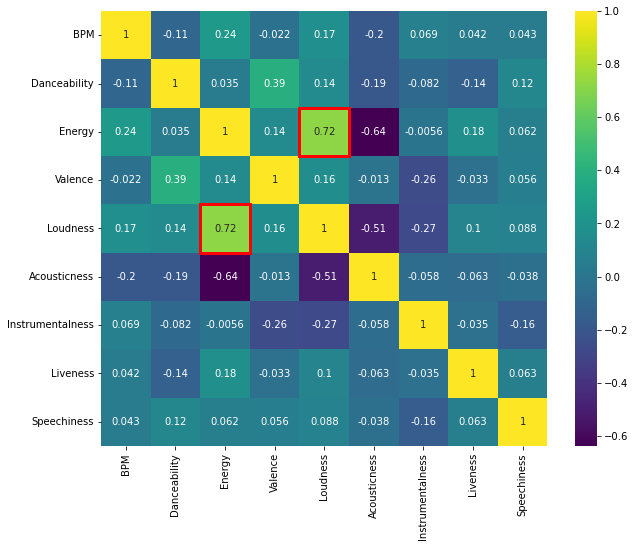

In [53]:
corr = final_dataset.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(corr, cmap='viridis', annot=True)
ax.add_patch(Rectangle((2, 4), 1, 1, fill=False, edgecolor='red', lw=3))
ax.add_patch(Rectangle((4, 2), 1, 1, fill=False, edgecolor='red', lw=3));

Creating a scatterplot to show every song's energy and danceability score by sub-genre. BPM (tempo) is also shown by the point's size.

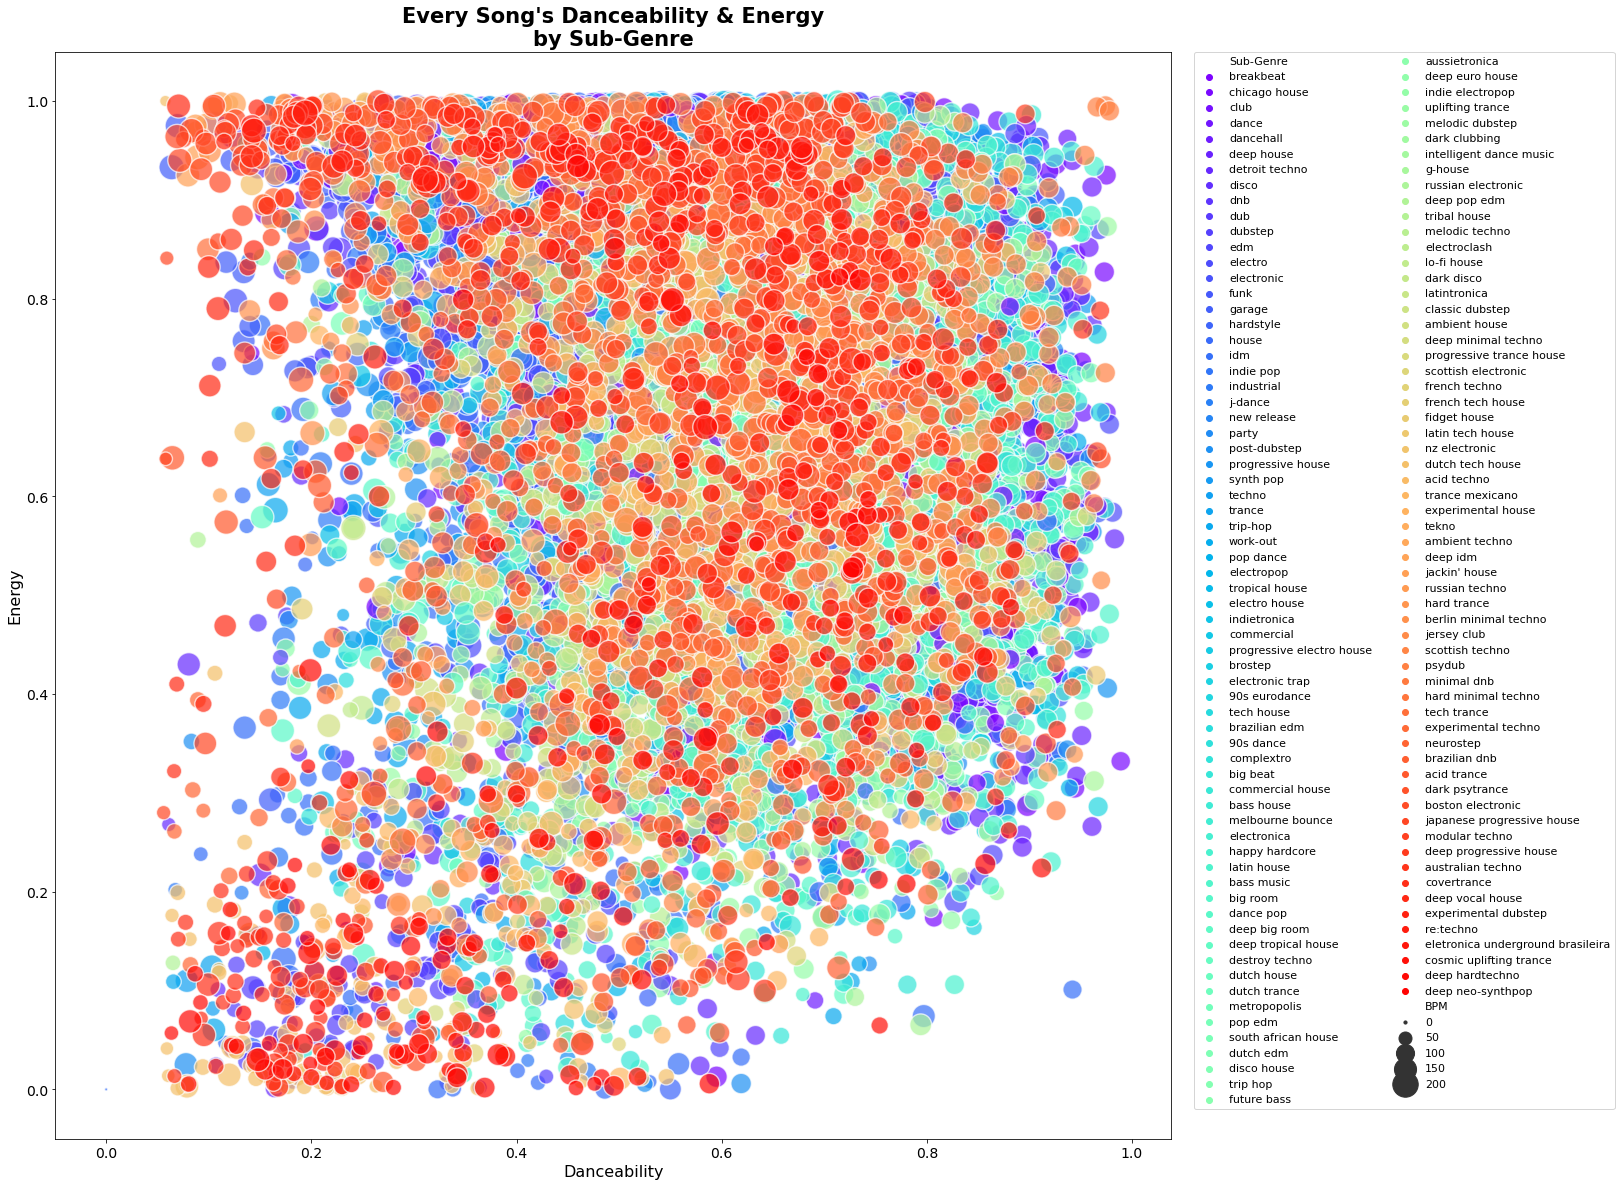

In [54]:
plt.figure(figsize=(20,20))

ax = sns.scatterplot(data=final_dataset, x='Danceability', y='Energy', 
                     hue='Sub-Genre', palette='rainbow',
                     size='BPM', sizes=(10,800), 
                     alpha=0.7)

ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=11, ncol=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Danceability', fontsize=16)
plt.ylabel('Energy', fontsize=16)
plt.title("Every Song's Danceability & Energy\nby Sub-Genre", fontsize=21, fontweight='bold');

Charting the mean danceability score per sub-genre

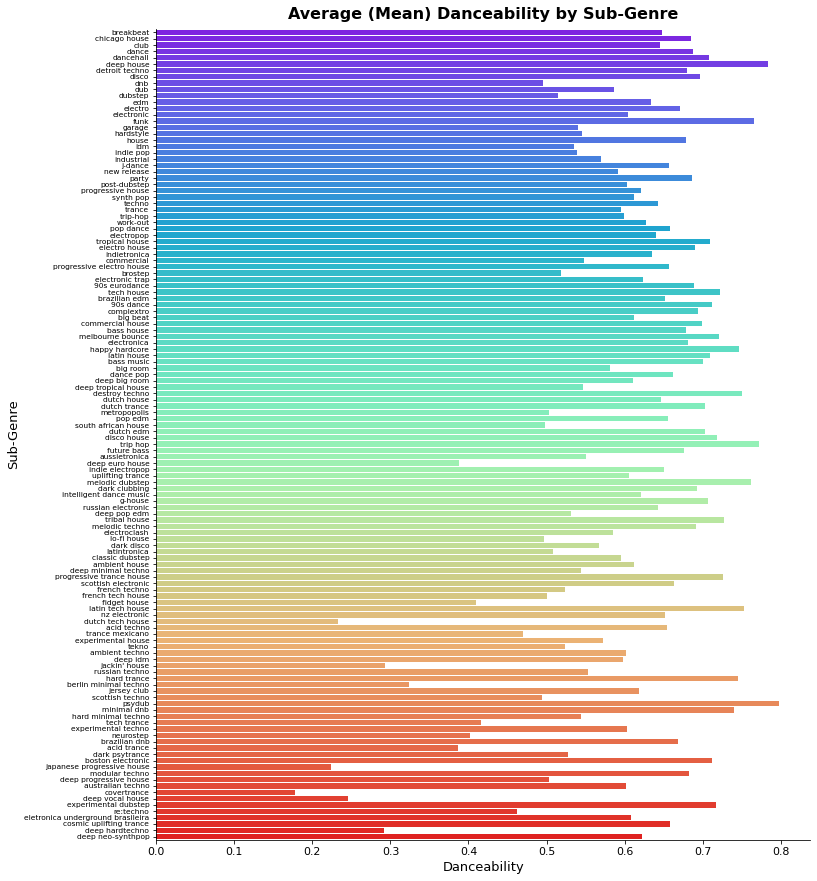

In [55]:
sns.catplot(x='Danceability', y='Sub-Genre', data=final_dataset, kind='bar',
            palette='rainbow', height=12, aspect=1, ci=None)
plt.xticks(fontsize=11)
plt.yticks(fontsize=7.5)
plt.xlabel('Danceability', fontsize=13)
plt.ylabel('Sub-Genre', fontsize=13)
plt.title('Average (Mean) Danceability by Sub-Genre', fontsize=16,
          pad=10, fontweight='bold');

## Modeling (Genres Included) <a name="modelinggenres"></a>
***
The data used in this section is the scaled DataFrame ***with*** one-hot encoded sub-genres. This will yield recommendations from the same sub-genre as the input reference song.

5 models displayed in this section:
1. A simple distance-based model using NumPy's linalg.norm function
2. Cosine Similarity
3. K-Nearest Neighbors
4. Sigmoid Kernel
5. Polynomial Kernel

Additional models also built and tested with recommendations:
1. x² Kernel
2. Laplacian Kernel
3. Linear Kernel
4. RBF (Gaussian) Kernel

Because the recommendations of the second batch of 4 models don't yield much difference from the cosine similarity or sigmoid kernel functions, they're discarded. The polynomial kernel function is left at the bottom of this section simply to confirm those findings. Again, it's not used as a "final model."

### Simple Distance-Based Model
This distance-based model takes an input vector (np.array) of all of the audio features (energy, danceability, etc.) and calculates the Euclidean norm of the flattened array.

The results are, quite frankly, terrible. The recommendations are from seemingly random sub-genres, the tempos (BPM) aren't anywhere near the reference song's 128 BPM (that's particularly bad) and nothing matches in energy or valence. As such, this won't be built or called again.

In [56]:
def distance_recommend(song_id, dataset_name, sp, n_recs=10):

    new_dataset = dataset_name.copy()

    new_dataset['BPM_scal'] = MinMaxScaler().fit_transform(dataset_name[['BPM']])

    new_dataset['all_features'] = new_dataset[['Danceability', 'Energy', 'Valence',
                                               'Loudness', 'Acousticness', 'Liveness',
                                               'Instrumentalness', 'Speechiness',
                                               'BPM_scal']].values.tolist()

    track_features = sp.track_audio_features(song_id)
    track_moodvec = np.array([track_features.acousticness, track_features.danceability,
                              track_features.energy, track_features.instrumentalness,
                              track_features.liveness, track_features.loudness,
                              track_features.speechiness, track_features.tempo,
                              track_features.valence])
    
    new_dataset['distances'] = new_dataset['all_features'].apply(lambda x: norm(track_moodvec-np.array(x)))

    rec_df_sorted = new_dataset.sort_values(by='distances', ascending=True)
    rec_df_sorted = rec_df_sorted[rec_df_sorted['ID'] != song_id]
    rec_df_sorted = rec_df_sorted.iloc[:n_recs]
    rec_df_sorted = rec_df_sorted[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

    return rec_df_sorted

**Reference song:** Nicky Romero - Camorra

In [57]:
distance_recommend('4oxi4THAaIzqtlazBV06uP', final_dataset, sp)

Artists                             Song_Title     Sub-Genre  \
8154              onra                               my comet  post-dubstep   
7720       roger molls                      my life ft detin8      trip-hop   
6426        disclosure                          willing  able         dance   
7606              jayz  public service announcement interlude         party   
10203         sub zero                               spin doc           dnb   
4459   various artists                                 tun up     dancehall   
3553             zatox   kings of the underground  radio edit     hardstyle   
3982        robot koch                                   nano  post-dubstep   
4817   various artists                                 flight    electronic   
7703             unkle       guns blazing drums of death pt 1      trip-hop   

           BPM  
8154   174.509  
7720   180.063  
6426   199.727  
7606   178.213  
10203  174.977  
4459   110.917  
3553    75.781  
3982   170.096  
4817    87.383  
7703    92.694

### Cosine Similarity Model
Cosine similarity consistently delivers valid recommendations across multiple reference songs. Using this particular reference song, these are all playable recommendations:
- Tiësto - Chasing Summers (Miami)
- Thomas Gold - Sing2Me
- Sander van Doorn - Koko
- Tiësto - What Can We Do (A Deeper Love) (Third Party Remix)

Creating a cosine similarity matrix of all 22,973 songs scored against each other

In [58]:
cosine = cosine_similarity(scaled_df)
cosine_df = pd.DataFrame(data=cosine, index=scaled_df.index)
cosine_df

0         1         2         3         4      \
ID                                                                         
6TZHtS4pLhJhSEfyV7bmyj  1.000000  0.930867  0.925192  0.868333  0.885449   
4w3zR0z2oqv8ijhOkTnRvT  0.930867  1.000000  0.877172  0.802338  0.810609   
4bdMXcKvjt705kx05H7FSk  0.925192  0.877172  1.000000  0.874658  0.882702   
5MomjGgGkxqYwyX7cRq8TC  0.868333  0.802338  0.874658  1.000000  0.983219   
42iBqLosPxTVZDTWkdQRpt  0.885449  0.810609  0.882702  0.983219  1.000000   
...                          ...       ...       ...       ...       ...   
3gX7krFtBrGMyLrCXWmpa7  0.547582  0.666507  0.635360  0.494803  0.510143   
4cdgHCCxg3eU0VnLDrGQHs  0.587109  0.614849  0.683682  0.569658  0.571632   
6wLrYh6LzNHg8LFNMYIu7B  0.594588  0.631290  0.601147  0.546064  0.559149   
7DsWxAoG3CPFTIbU2JPwQC  0.577044  0.660350  0.678122  0.560457  0.564583   
4fCV2kvqf1Kcs333J60gEI  0.600165  0.585251  0.706029  0.601705  0.604452   

                           5         6         7         8         9      ...  \
ID                                                                        ...   
6TZHtS4pLhJhSEfyV7bmyj  0.908960  0.956706  0.960457  0.853051  0.957187  ...   
4w3zR0z2oqv8ijhOkTnRvT  0.846182  0.887606  0.882132  0.847668  0.877283  ...   
4bdMXcKvjt705kx05H7FSk  0.953308  0.984015  0.955104  0.914597  0.966151  ...   
5MomjGgGkxqYwyX7cRq8TC  0.847799  0.892330  0.906548  0.945868  0.912751  ...   
42iBqLosPxTVZDTWkdQRpt  0.897340  0.905982  0.945514  0.931468  0.943082  ...   
...                          ...       ...       ...       ...       ...  ...   
3gX7krFtBrGMyLrCXWmpa7  0.598805  0.591521  0.566916  0.623275  0.577753  ...   
4cdgHCCxg3eU0VnLDrGQHs  0.646448  0.645060  0.623911  0.624639  0.633352  ...   
6wLrYh6LzNHg8LFNMYIu7B  0.583957  0.601554  0.600376  0.553492  0.610435  ...   
7DsWxAoG3CPFTIbU2JPwQC  0.641720  0.637129  0.614242  0.633828  0.624628  ...   
4fCV2kvqf1Kcs333J60gEI  0.672972  0.677343  0.652617  0.626157  0.667992  ...   

                           22963     22964     22965     22966     22967  \
ID                                                                         
6TZHtS4pLhJhSEfyV7bmyj  0.625050  0.574790  0.526922  0.534070  0.528564   
4w3zR0z2oqv8ijhOkTnRvT  0.599830  0.663722  0.638157  0.596131  0.665219   
4bdMXcKvjt705kx05H7FSk  0.705621  0.645133  0.548410  0.538043  0.630776   
5MomjGgGkxqYwyX7cRq8TC  0.618624  0.547418  0.490847  0.605379  0.505705   
42iBqLosPxTVZDTWkdQRpt  0.627327  0.546174  0.498339  0.614545  0.517382   
...                          ...       ...       ...       ...       ...   
3gX7krFtBrGMyLrCXWmpa7  0.885121  0.962256  0.937054  0.888717  0.981310   
4cdgHCCxg3eU0VnLDrGQHs  0.976806  0.979729  0.933507  0.902843  0.939055   
6wLrYh6LzNHg8LFNMYIu7B  0.958572  0.967950  0.971168  0.942938  0.911945   
7DsWxAoG3CPFTIbU2JPwQC  0.950278  0.994433  0.961161  0.908726  0.980290   
4fCV2kvqf1Kcs333J60gEI  0.993025  0.950767  0.899180  0.873826  0.898706   

                           22968     22969     22970     22971     22972  
ID                                                                        
6TZHtS4pLhJhSEfyV7bmyj  0.547582  0.587109  0.594588  0.577044  0.600165  
4w3zR0z2oqv8ijhOkTnRvT  0.666507  0.614849  0.631290  0.660350  0.585251  
4bdMXcKvjt705kx05H7FSk  0.635360  0.683682  0.601147  0.678122  0.706029  
5MomjGgGkxqYwyX7cRq8TC  0.494803  0.569658  0.546064  0.560457  0.601705  
42iBqLosPxTVZDTWkdQRpt  0.510143  0.571632  0.559149  0.564583  0.604452  
...                          ...       ...       ...       ...       ...  
3gX7krFtBrGMyLrCXWmpa7  1.000000  0.940304  0.919864  0.971930  0.895281  
4cdgHCCxg3eU0VnLDrGQHs  0.940304  1.000000  0.956887  0.985034  0.988982  
6wLrYh6LzNHg8LFNMYIu7B  0.919864  0.956887  1.000000  0.953474  0.942550  
7DsWxAoG3CPFTIbU2JPwQC  0.971930  0.985034  0.953474  1.000000  0.961275  
4fCV2kvqf1Kcs333J60gEI  0.895281  0.988982  0.942550  0.961275  1.000000  

[22973 rows x 22973

Writing a function that takes 3 inputs (artist, song title, number of recommendations), finds the song in the cosine similarity matrix above, sorts the scores in descending order and returns a DataFrame of the top number of songs input as the number of recommendations.

In [59]:
def cosine_recommend():
    
    # Handle the inputs
    artist_input = input('Artist: ')
    artist_input = artist_input.lower().strip()
    song_input = input('Song title: ')
    song_input = song_input.lower().strip()
    n_recs = int(input('Number of recommendations: '))
    
    # Deal with inputs not in database
    artist = list(final_dataset[final_dataset['Artists'].str.contains(artist_input,
                                                    case=False, regex=False)].index)
    song = list(final_dataset[final_dataset['Song_Title'].str.contains(song_input,
                                                    case=False, regex=False)].index)
    idx = 0
    
    if not artist or not song:
        print('\n##### PROVIDED SONG NOT IN DATABASE #####')
        return None
    
    else:
    
        # Find index value of reference song
        a = final_dataset['Artists'].str.findall(artist_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        s = final_dataset['Song_Title'].str.findall(song_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        try:
            idx = (set(a) & set(s)).pop()
        except KeyError:
            print('\n##### PROVIDED SONG NOT IN DATABASE #####')
            return None

    # Use index value to find song ID
    song_id = final_dataset.iloc[idx]['ID']

    # Create a DataFrame of the top n recommended songs
    top_rec_dict = dict(cosine_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
    top_n_recs = pd.DataFrame()
    for i in list(top_rec_dict.keys()):
        song_row = final_dataset.iloc[i]
        top_n_recs = top_n_recs.append(song_row)
        top_n_recs = top_n_recs[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

    # Display the input reference song and recommendations
    artist_name = final_dataset.iloc[idx]['Artists']
    song_name = final_dataset.iloc[idx]['Song_Title']
    print(f'\nProvided song: {artist_name} - {song_name}')
    return top_n_recs.style.hide_index()

Calling the cosine function and inputing 10 recommendations for the reference song

In [60]:
cosine_recommend()

Artist: romero
Song title: camorra
Number of recommendations: 10

Provided song: nicky romero - camorra  original mix


### K-Nearest Neighbors Model
KNN also yields strong recommendations across multiple reference songs. Sometimes, as is the case with this reference song, there's a bit of overlap with cosine similarity, which only confirms the validity of the recommendations. In addition to the same 4 recommendations from cosine similarity above, *Inpetto - No More Serious Faces* is also a playable recommendation.

The following hyperparameter values were tested:
1. metric
    - manhattan 
    - minkowski
    - euclidean
    - chebyshev
2. algorithm
    - brute
    - ball_tree
    - kd_tree
    - auto
3. n_neighbors
    - 3
    - 5
    - 7
    - 9
    - 11

*Metric='manhattan', algorithm='brute', n_neighbors=7* yields the most variety from cosine similarity and is therefore used. Other combinations generate nearly identical results, providing no additional value.

Writing a function that takes 3 inputs (artist, song title, number of recommendations), finds the song in the final DataFrame, fits the KNN model to the scaled DataFrame, finds n number of recommendation neighbors and returns a DataFrame of the top number of those neighbors.

In [61]:
def knn_recommend():
    
    # Handle the inputs
    artist_input = input('Artist: ')
    artist_input = artist_input.lower().strip()
    song_input = input('Song title: ')
    song_input = song_input.lower().strip()
    n_recs = int(input('Number of recommendations: '))
    
    # Deal with inputs not in database
    artist = list(final_dataset[final_dataset['Artists'].str.contains(artist_input,
                                                    case=False, regex=False)].index)
    song = list(final_dataset[final_dataset['Song_Title'].str.contains(song_input,
                                                    case=False, regex=False)].index)
    idx = 0
    
    if not artist or not song:
        print('\n##### PROVIDED SONG NOT IN DATABASE #####')
        return None
    
    else:
    
        # Find index value of reference song
        a = final_dataset['Artists'].str.findall(artist_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        s = final_dataset['Song_Title'].str.findall(song_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        try:
            idx = (set(a) & set(s)).pop()
        except KeyError:
            print('\n##### PROVIDED SONG NOT IN DATABASE #####')
            return None

    # Use index value to find song ID
    song_id = final_dataset.iloc[idx]['ID']

    # Fit KNN model to scaled data
    knn = NearestNeighbors(metric='manhattan', algorithm='brute', n_neighbors=7)
    knn.fit(scaled_df)

    # Find n number of neighbors
    indices = knn.kneighbors(scaled_df.loc[[song_id]], (n_recs+1), return_distance=False)

    # Create a DataFrame of the top n recommended songs
    knn_df = pd.DataFrame()
    for i in indices[:,1:]:
        knn_df = knn_df.append(final_dataset.iloc[i])
    knn_df = knn_df[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

    # Display the input reference song and recommendations
    artist_name = final_dataset.iloc[idx]['Artists']
    song_name = final_dataset.iloc[idx]['Song_Title']
    print(f'\nProvided song: {artist_name} - {song_name}')
    return knn_df.style.hide_index()

Calling the KNN function and inputing 10 recommendations for the reference song

In [62]:
knn_recommend()

Artist: romero
Song title: camorra
Number of recommendations: 10

Provided song: nicky romero - camorra  original mix


### Sigmoid Kernel Model
Generally speaking, sigmoid kernel generates recommendations that differ from cosine similarity and, in particular, KNN. The recommendations are still playable so it provides a nice compliment to the other two. Using this particular reference, these are playable recommendations:
- Nicky Romero - Solar
- Basto & Yves V - CloudBreaker

Creating a sigmoid kernel matrix of all 22,973 songs scored against each other

In [63]:
sig_kernel = sigmoid_kernel(scaled_df)
sig_kernel_df = pd.DataFrame(data=sig_kernel, index=scaled_df.index)
sig_kernel_df

0         1         2         3         4      \
ID                                                                         
6TZHtS4pLhJhSEfyV7bmyj  0.769325  0.769409  0.770496  0.769954  0.770272   
4w3zR0z2oqv8ijhOkTnRvT  0.769409  0.770691  0.770757  0.769984  0.770224   
4bdMXcKvjt705kx05H7FSk  0.770496  0.770757  0.773528  0.772057  0.772343   
5MomjGgGkxqYwyX7cRq8TC  0.769954  0.769984  0.772057  0.773519  0.773536   
42iBqLosPxTVZDTWkdQRpt  0.770272  0.770224  0.772343  0.773536  0.773955   
...                          ...       ...       ...       ...       ...   
3gX7krFtBrGMyLrCXWmpa7  0.766797  0.768451  0.769092  0.767449  0.767739   
4cdgHCCxg3eU0VnLDrGQHs  0.766546  0.767219  0.768757  0.767573  0.767704   
6wLrYh6LzNHg8LFNMYIu7B  0.766325  0.767042  0.767547  0.767005  0.767235   
7DsWxAoG3CPFTIbU2JPwQC  0.766829  0.768086  0.769234  0.767922  0.768084   
4fCV2kvqf1Kcs333J60gEI  0.766775  0.767079  0.769164  0.768056  0.768204   

                           5         6         7         8         9      ...  \
ID                                                                        ...   
6TZHtS4pLhJhSEfyV7bmyj  0.770615  0.770035  0.770178  0.769958  0.770443  ...   
4w3zR0z2oqv8ijhOkTnRvT  0.770714  0.770099  0.770158  0.770610  0.770404  ...   
4bdMXcKvjt705kx05H7FSk  0.773335  0.772376  0.772201  0.772722  0.772688  ...   
5MomjGgGkxqYwyX7cRq8TC  0.772057  0.771386  0.771668  0.773090  0.772083  ...   
42iBqLosPxTVZDTWkdQRpt  0.772856  0.771713  0.772284  0.773124  0.772621  ...   
...                          ...       ...       ...       ...       ...  ...   
3gX7krFtBrGMyLrCXWmpa7  0.768887  0.768002  0.767820  0.769082  0.768156  ...   
4cdgHCCxg3eU0VnLDrGQHs  0.768583  0.767797  0.767674  0.768262  0.767978  ...   
6wLrYh6LzNHg8LFNMYIu7B  0.767559  0.767056  0.767117  0.767177  0.767403  ...   
7DsWxAoG3CPFTIbU2JPwQC  0.769055  0.768183  0.768033  0.768868  0.768366  ...   
4fCV2kvqf1Kcs333J60gEI  0.769039  0.768258  0.768102  0.768437  0.768483  ...   

                           22963     22964     22965     22966     22967  \
ID                                                                         
6TZHtS4pLhJhSEfyV7bmyj  0.767094  0.766639  0.765821  0.765881  0.766701   
4w3zR0z2oqv8ijhOkTnRvT  0.767325  0.767907  0.767141  0.766782  0.768552   
4bdMXcKvjt705kx05H7FSk  0.769307  0.768631  0.767069  0.766970  0.769162   
5MomjGgGkxqYwyX7cRq8TC  0.768366  0.767575  0.766498  0.767633  0.767676   
42iBqLosPxTVZDTWkdQRpt  0.768585  0.767671  0.766663  0.767836  0.767929   
...                          ...       ...       ...       ...       ...   
3gX7krFtBrGMyLrCXWmpa7  0.771052  0.771826  0.770706  0.770249  0.773056   
4cdgHCCxg3eU0VnLDrGQHs  0.770857  0.770854  0.769664  0.769408  0.771357   
6wLrYh6LzNHg8LFNMYIu7B  0.770177  0.770231  0.769513  0.769291  0.770548   
7DsWxAoG3CPFTIbU2JPwQC  0.771286  0.771694  0.770523  0.770048  0.772539   
4fCV2kvqf1Kcs333J60gEI  0.771231  0.770797  0.769556  0.769339  0.771166   

                           22968     22969     22970     22971     22972  
ID                                                                        
6TZHtS4pLhJhSEfyV7bmyj  0.766797  0.766546  0.766325  0.766829  0.766775  
4w3zR0z2oqv8ijhOkTnRvT  0.768451  0.767219  0.767042  0.768086  0.767079  
4bdMXcKvjt705kx05H7FSk  0.769092  0.768757  0.767547  0.769234  0.769164  
5MomjGgGkxqYwyX7cRq8TC  0.767449  0.767573  0.767005  0.767922  0.768056  
42iBqLosPxTVZDTWkdQRpt  0.767739  0.767704  0.767235  0.768084  0.768204  
...                          ...       ...       ...       ...       ...  
3gX7krFtBrGMyLrCXWmpa7  0.773081  0.771211  0.770478  0.772272  0.770975  
4cdgHCCxg3eU0VnLDrGQHs  0.771211  0.770677  0.769804  0.771214  0.770791  
6wLrYh6LzNHg8LFNMYIu7B  0.770478  0.769804  0.769686  0.770389  0.769874  
7DsWxAoG3CPFTIbU2JPwQC  0.772272  0.771214  0.770389  0.772089  0.771209  
4fCV2kvqf1Kcs333J60gEI  0.770975  0.770791  0.769874  0.771209  0.771112  

[22973 rows x 22973

Writing a function that takes 3 inputs (artist, song title, number of recommendations), finds the song in the sigmoid kernel matrix above, sorts the scores in descending order and returns a DataFrame of the top number of songs input as the number of recommendations.

In [64]:
def sig_kernel_recommend():
    
    # Handle the inputs
    artist_input = input('Artist: ')
    artist_input = artist_input.lower().strip()
    song_input = input('Song title: ')
    song_input = song_input.lower().strip()
    n_recs = int(input('Number of recommendations: '))
    
    # Deal with inputs not in database
    artist = list(final_dataset[final_dataset['Artists'].str.contains(artist_input,
                                                    case=False, regex=False)].index)
    song = list(final_dataset[final_dataset['Song_Title'].str.contains(song_input,
                                                    case=False, regex=False)].index)
    idx = 0
    
    if not artist or not song:
        print('\n##### PROVIDED SONG NOT IN DATABASE #####')
        return None
    
    else:
    
        # Find index value of reference song
        a = final_dataset['Artists'].str.findall(artist_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        s = final_dataset['Song_Title'].str.findall(song_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        try:
            idx = (set(a) & set(s)).pop()
        except KeyError:
            print('\n##### PROVIDED SONG NOT IN DATABASE #####')
            return None

    # Use index value to find song ID
    song_id = final_dataset.iloc[idx]['ID']

    # Create a DataFrame of the top n recommended songs
    top_rec_dict = dict(sig_kernel_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
    top_n_recs = pd.DataFrame()
    for i in list(top_rec_dict.keys()):
        song_row = final_dataset.iloc[i]
        top_n_recs = top_n_recs.append(song_row)
        top_n_recs = top_n_recs[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

    # Display the input reference song and recommendations
    artist_name = final_dataset.iloc[idx]['Artists']
    song_name = final_dataset.iloc[idx]['Song_Title']
    print(f'\nProvided song: {artist_name} - {song_name}')
    return top_n_recs.style.hide_index()

Calling the sigmoid kernel function and inputing 10 recommendations for the reference song

In [65]:
sig_kernel_recommend()

Artist: romero
Song title: camorra
Number of recommendations: 10

Provided song: nicky romero - camorra  original mix


### Polynomial Kernel Model (not used)
This is one of the additional 5 kernel functions that doesn't offer different recommendations from cosine similarity, KNN or sigmoid kernel. As such, it's not used. The other 4 kernel functions (listed above) are discarded.

In [66]:
### FOR TESTING ONLY ###
poly = polynomial_kernel(scaled_df)
poly_df = pd.DataFrame(data=poly, index=scaled_df.index)

In [67]:
### FOR TESTING ONLY ###
def poly_recommend():
    
    artist_input = input('Artist: ')
    artist_input = artist_input.lower().strip()
    song_input = input('Song title: ')
    song_input = song_input.lower().strip()
    n_recs = int(input('Number of recommendations: '))
    
    artist = list(final_dataset[final_dataset['Artists'].str.contains(artist_input,
                                                    case=False, regex=False)].index)
    song = list(final_dataset[final_dataset['Song_Title'].str.contains(song_input,
                                                    case=False, regex=False)].index)
    idx = 0
    
    if not artist or not song:
        print('\n##### PROVIDED SONG NOT IN DATABASE #####')
        return None
    
    else:
    
        a = final_dataset['Artists'].str.findall(artist_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        s = final_dataset['Song_Title'].str.findall(song_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        try:
            idx = (set(a) & set(s)).pop()
        except KeyError:
            print('\n##### PROVIDED SONG NOT IN DATABASE #####')
            return None

    song_id = final_dataset.iloc[idx]['ID']

    top_rec_dict = dict(poly_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
    top_n_recs = pd.DataFrame()
    for i in list(top_rec_dict.keys()):
        song_row = final_dataset.iloc[i]
        top_n_recs = top_n_recs.append(song_row)
        top_n_recs = top_n_recs[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

    artist_name = final_dataset.iloc[idx]['Artists']
    song_name = final_dataset.iloc[idx]['Song_Title']
    print(f'\nProvided song: {artist_name} - {song_name}')
    return top_n_recs.style.hide_index()

In [68]:
### FOR TESTING ONLY ###
poly_recommend()

Artist: romero
Song title: camorra
Number of recommendations: 10

Provided song: nicky romero - camorra  original mix


## Modeling (No Genres) <a name="modelingnogenres"></a>
***
The data used in this section is the scaled DataFrame ***without*** one-hot encoded sub-genres. This will yield recommendations across all sub-genres regardless of the input reference song's own sub-genre.

To prevent redundancy, only the 3 final models are used:
1. Cosine Similarity
2. K-Nearest Neighbors
3. Sigmoid Kernel

### Cosine Similarity (No Genres) Model
Same process as cosine similarity above just using the scaled DataFrame without one-hot encoded sub-genres.

These are the playable recommendations:
- R3hab - The Bottle Song (D-wayne Remix)
- Tiësto - Chasing Summers (Miami)  \*Also found in other cosine similarity results

Creating a cosine similarity matrix of all 22,973 songs scored against each other

In [69]:
cosine_no_genre = cosine_similarity(no_genre_df)
cosine_no_genre_df = pd.DataFrame(data=cosine_no_genre, index=no_genre_df.index)

Writing a function that takes 3 inputs (artist, song title, number of recommendations), finds the song in the cosine similarity matrix above, sorts the scores in descending order and returns a DataFrame of the top number of songs input as the number of recommendations.

In [70]:
def cosine_recommend_no_genre():
    
    # Handle the inputs
    artist_input = input('Artist: ')
    artist_input = artist_input.lower().strip()
    song_input = input('Song title: ')
    song_input = song_input.lower().strip()
    n_recs = int(input('Number of recommendations: '))
    
    # Deal with inputs not in database
    artist = list(final_dataset[final_dataset['Artists'].str.contains(artist_input,
                                                    case=False, regex=False)].index)
    song = list(final_dataset[final_dataset['Song_Title'].str.contains(song_input,
                                                    case=False, regex=False)].index)
    idx = 0
    
    if not artist or not song:
        print('\n##### PROVIDED SONG NOT IN DATABASE #####')
        return None
    
    else:
    
        # Find index value of reference song
        a = final_dataset['Artists'].str.findall(artist_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        s = final_dataset['Song_Title'].str.findall(song_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        try:
            idx = (set(a) & set(s)).pop()
        except KeyError:
            print('\n##### PROVIDED SONG NOT IN DATABASE #####')
            return None

    # Use index value to find song ID
    song_id = final_dataset.iloc[idx]['ID']

    # Create a DataFrame of the top n recommended songs
    top_rec_dict = dict(cosine_no_genre_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
    top_n_recs = pd.DataFrame()
    for i in list(top_rec_dict.keys()):
        song_row = final_dataset.iloc[i]
        top_n_recs = top_n_recs.append(song_row)
        top_n_recs = top_n_recs[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

    # Display the input reference song and recommendations
    artist_name = final_dataset.iloc[idx]['Artists']
    song_name = final_dataset.iloc[idx]['Song_Title']
    print(f'\nProvided song: {artist_name} - {song_name}')
    return top_n_recs.style.hide_index()

Calling the cosine similarity function and inputing 10 recommendations for the reference song

In [71]:
cosine_recommend_no_genre()

Artist: romero
Song title: camorra
Number of recommendations: 10

Provided song: nicky romero - camorra  original mix


### K-Nearest Neighbors (No Genres) Model
Same process as KNN above just using the scaled DataFrame without one-hot encoded sub-genres.

2 playable recommendations found in previous models.

Writing a function that takes 3 inputs (artist, song title, number of recommendations), finds the song in the final DataFrame, fits the KNN model to the scaled DataFrame, finds n number of recommendation neighbors and returns a DataFrame of the top number of those neighbors.

In [72]:
def knn_recommend_no_genre():
    
    # Handle the inputs
    artist_input = input('Artist: ')
    artist_input = artist_input.lower().strip()
    song_input = input('Song title: ')
    song_input = song_input.lower().strip()
    n_recs = int(input('Number of recommendations: '))
    
    # Deal with inputs not in database
    artist = list(final_dataset[final_dataset['Artists'].str.contains(artist_input,
                                                    case=False, regex=False)].index)
    song = list(final_dataset[final_dataset['Song_Title'].str.contains(song_input,
                                                    case=False, regex=False)].index)
    idx = 0
    
    if not artist or not song:
        print('\n##### PROVIDED SONG NOT IN DATABASE #####')
        return None
    
    else:
    
        # Find index value of reference song
        a = final_dataset['Artists'].str.findall(artist_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        s = final_dataset['Song_Title'].str.findall(song_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        try:
            idx = (set(a) & set(s)).pop()
        except KeyError:
            print('\n##### PROVIDED SONG NOT IN DATABASE #####')
            return None

    # Use index value to find song ID
    song_id = final_dataset.iloc[idx]['ID']

    # Fit KNN model to scaled data
    knn = NearestNeighbors(metric='manhattan', algorithm='brute', n_neighbors=7)
    knn.fit(no_genre_df)

    # Find n number of neighbors
    indices = knn.kneighbors(no_genre_df.loc[[song_id]], (n_recs+1), return_distance=False)

    # Create a DataFrame of the top n recommended songs
    knn_df = pd.DataFrame()
    for i in indices[:,1:]:
        knn_df = knn_df.append(final_dataset.iloc[i])
    knn_df = knn_df[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

    # Display the input reference song and recommendations
    artist_name = final_dataset.iloc[idx]['Artists']
    song_name = final_dataset.iloc[idx]['Song_Title']
    print(f'\nProvided song: {artist_name} - {song_name}')
    return knn_df.style.hide_index()

Calling the KNN function and inputing 10 recommendations for the reference song

In [73]:
knn_recommend_no_genre()

Artist: romero
Song title: camorra
Number of recommendations: 10

Provided song: nicky romero - camorra  original mix


### Sigmoid Kernel (No Genres) Model
Same process as sigmoid kernel above just using the scaled DataFrame without one-hot encoded sub-genres.

Playable recommendation:
- Julian Jordan & Martin Garrix - BFAM

Creating a sigmoid kernel matrix of all 22,973 songs scored against each other

In [74]:
sig_no_genre = sigmoid_kernel(no_genre_df)
sig_no_genre_df = pd.DataFrame(data=sig_no_genre, index=no_genre_df.index)

Writing a function that takes 3 inputs (artist, song title, number of recommendations), finds the song in the sigmoid kernel matrix above, sorts the scores in descending order and returns a DataFrame of the top number of songs input as the number of recommendations.

In [75]:
def sig_kernel_recommend_no_genre():
    
    # Handle the inputs
    artist_input = input('Artist: ')
    artist_input = artist_input.lower().strip()
    song_input = input('Song title: ')
    song_input = song_input.lower().strip()
    n_recs = int(input('Number of recommendations: '))
    
    # Deal with inputs not in database
    artist = list(final_dataset[final_dataset['Artists'].str.contains(artist_input,
                                                    case=False, regex=False)].index)
    song = list(final_dataset[final_dataset['Song_Title'].str.contains(song_input,
                                                    case=False, regex=False)].index)
    idx = 0
    
    if not artist or not song:
        print('\n##### PROVIDED SONG NOT IN DATABASE #####')
        return None
    
    else:
    
        # Find index value of reference song
        a = final_dataset['Artists'].str.findall(artist_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        s = final_dataset['Song_Title'].str.findall(song_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        try:
            idx = (set(a) & set(s)).pop()
        except KeyError:
            print('\n##### PROVIDED SONG NOT IN DATABASE #####')
            return None

    # Use index value to find song ID
    song_id = final_dataset.iloc[idx]['ID']

    # Create a DataFrame of the top n recommended songs
    top_rec_dict = dict(sig_no_genre_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
    top_n_recs = pd.DataFrame()
    for i in list(top_rec_dict.keys()):
        song_row = final_dataset.iloc[i]
        top_n_recs = top_n_recs.append(song_row)
        top_n_recs = top_n_recs[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

    # Display the input reference song and recommendations
    artist_name = final_dataset.iloc[idx]['Artists']
    song_name = final_dataset.iloc[idx]['Song_Title']
    print(f'\nProvided Song: {artist_name} - {song_name}')
    return top_n_recs.style.hide_index()

Calling the sigmoid kernel function and inputing 10 recommendations for the reference song

In [76]:
sig_kernel_recommend_no_genre()

Artist: romero
Song title: camorra
Number of recommendations: 10

Provided Song: nicky romero - camorra  original mix


## Final Model Function <a name="finalmodel"></a>
***
Putting the final 3 models together into 1 function.

Writing a function that takes 3 inputs (artist, song title, recommendations from same genre), finds the song in the same capacity as the models above, sorts the scores in descending order and returns a DataFrame of the top songs. Since identical recommendations are common across the models, duplicates need to be dropped. Rather than limiting to a total number of recommendations, 10 recommendations are requested of each of the 3 models by default. This may or may not yield 30 total recommendations depending on the number of duplicates dropped.

In [77]:
def recommend(recs=None):
    
    """
    Inputs:
    1. Artist Name: Can be full or partial name, not to include punctuation (string)
    2. Song Title: Can be full or partial title, not to include punctuation (string)
    3. Genre: Yes or No (string)
    """
    
    # Handle the inputs
    artist_input = input('Artist: ')
    artist_input = artist_input.lower().strip()
    song_input = input('Song title: ')
    song_input = song_input.lower().strip()
    if recs == None:
        n_recs = 10
    else:
        n_recs = recs
    genres = input('Recommendations from the same genre? ')
    genres = genres.lower().strip()
    
    # Deal with inputs not in database
    artist = list(final_dataset[final_dataset['Artists'].str.contains(artist_input,
                                                    case=False, regex=False)].index)
    song = list(final_dataset[final_dataset['Song_Title'].str.contains(song_input,
                                                    case=False, regex=False)].index)
    idx = 0
    
    if not artist or not song:
        print('\n##### PROVIDED SONG NOT IN DATABASE #####')
        return None
    
    else:
    
        # Find index value of reference song
        a = final_dataset['Artists'].str.findall(artist_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        s = final_dataset['Song_Title'].str.findall(song_input, flags=re.IGNORECASE).to_numpy().nonzero()[0]
        try:
            idx = (set(a) & set(s)).pop()
        except KeyError:
            print('\n##### PROVIDED SONG NOT IN DATABASE #####')
            return None

    # Use index value to find song ID, artist & song
    song_id = final_dataset.iloc[idx]['ID']
    artist_name = final_dataset.iloc[idx]['Artists']
    song_name = final_dataset.iloc[idx]['Song_Title']

    if genres[0] == 'n':

        # Cosine similarity (no genres)
        top_rec_dict = dict(cosine_no_genre_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
        cos_no_genre = pd.DataFrame()
        for i in list(top_rec_dict.keys()):
            song_row = final_dataset.iloc[i]
            cos_no_genre = cos_no_genre.append(song_row)
            cos_no_genre = cos_no_genre[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

        # KNN (no genres)
        knn = NearestNeighbors(metric='manhattan', algorithm='brute', n_neighbors=7)
        knn.fit(no_genre_df)
        indices = knn.kneighbors(no_genre_df.loc[[song_id]], (n_recs+1), return_distance=False)
        knn_no_genre = pd.DataFrame()
        for i in indices[:,1:]:
            knn_no_genre = knn_no_genre.append(final_dataset.iloc[i])
        knn_no_genre = knn_no_genre[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

        # Sigmoid kernel (no genres)
        top_rec = dict(sig_no_genre_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
        sig_no_genre = pd.DataFrame()
        for i in list(top_rec.keys()):
            song_row = final_dataset.iloc[i]
            sig_no_genre = sig_no_genre.append(song_row)
            sig_no_genre = sig_no_genre[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

        # Merge the recommendations
        final_no_genre = pd.concat([cos_no_genre, knn_no_genre, sig_no_genre])
        final_no_genre = final_no_genre.drop_duplicates(subset=['Artists', 'Song_Title'],
                                                        keep='first')
        final_no_genre = final_no_genre[~final_no_genre.reset_index().duplicated().values]
        final_no_genre = final_no_genre.sort_values('Artists')
        final_no_genre.index = np.arange(1, len(final_no_genre) + 1)

        # Display the input reference song, number of recs and recs
        print(f'\nProvided Song: {artist_name} - {song_name}')
        print(f'Top {len(final_no_genre.index)} recommendations across all genres')
        return final_no_genre

    else:

        # Cosine similarity (same genre)
        top_rec_dict = dict(cosine_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
        cos_df = pd.DataFrame()
        for i in list(top_rec_dict.keys()):
            song_row = final_dataset.iloc[i]
            cos_df = cos_df.append(song_row)
            cos_df = cos_df[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

        # KNN (same genre)
        knn = NearestNeighbors(metric='manhattan', algorithm='brute', n_neighbors=7)
        knn.fit(scaled_df)
        indices = knn.kneighbors(scaled_df.loc[[song_id]], (n_recs+1), return_distance=False)
        knn_df = pd.DataFrame()
        for i in indices[:,1:]:
            knn_df = knn_df.append(final_dataset.iloc[i])
        knn_df = knn_df[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

        # Sigmoid kernel (same genre)
        top_rec = dict(sig_kernel_df.loc[song_id].sort_values(ascending=False)[1:(n_recs+1)])
        sig_df = pd.DataFrame()
        for i in list(top_rec.keys()):
            song_row = final_dataset.iloc[i]
            sig_df = sig_df.append(song_row)
            sig_df = sig_df[['Artists', 'Song_Title', 'Sub-Genre', 'BPM']]

        # Merge the recommendations
        final_df = pd.concat([cos_df, knn_df, sig_df])
        final_df = final_df.drop_duplicates(subset=['Artists', 'Song_Title'],
                                            keep='first')
        final_df = final_df[~final_df.reset_index().duplicated().values]
        final_df = final_df.sort_values('Artists')
        final_df.index = np.arange(1, len(final_df) + 1)

        # Display the input reference song, number of recs and recs
        print(f'\nProvided song: {artist_name} - {song_name}')
        print(f'Top {len(final_df.index)} recommendations from the same genre')
        return final_df

Calling the final recommendation function, inputing 15 recommendations per model (an option) and keeping the recommendations within the same sub-genre

In [78]:
recommend(15)

Artist: romero
Song title: camorra
Recommendations from the same genre? yes

Provided song: nicky romero - camorra  original mix
Top 34 recommendations from the same genre


Artists  \
1          alan fitzpatrick, patrice rushen   
2                               albin myers   
3                   avicii vs lenny kravitz   
4                                     basto   
5                                     basto   
6                     camelphat, elderbrook   
7                                   chuckie   
8         dave armstrong, redroche, hboogie   
9                              david guetta   
10                              dirty south   
11                             earth n days   
12                       gorgon city, drama   
13                           hard rock sofa   
14                                 hardwell   
15                                  inpetto   
16                  kc lights, leo stannard   
17                            michael woods   
18                             nicky romero   
19                           oliver heldens   
20                           rebecca  fiona   
21                                 sam gray   
22                         sander van doorn   
23                         sander van doorn   
24                          sultan  shepard   
25                              thomas gold   
26                                   tiesto   
27                                   tiesto   
28                                      tjr   
29                        tobtok, jem cooke   
30  tom novy, cat dealers, michael marshall   
31                              tom zanetti   
32                          various artists   
33                          various artists   
34                                      wh0   

                                           Song_Title Sub-Genre      BPM  
1           havent you heard  fitzys half charged mix     house  130.007  
2                                                jump     house  128.010  
3       superlove avicii vs lenny kravitz  radio edit     house  127.959  
4                            i rave you  original mix     house  130.012  
5         cloud breaker feat yves v  basto radio edit     house  127.974  
6                                                cola     house  122.007  
7   what happens in vegas feat gregor salto  club mix     house  130.004  
8                     love has gone  fonzerelli remix     house  127.998  
9    turn me on  david guetta and laidback luke remix     house  128.031  
10                  let it go feat rudy  axwell remix     house  127.000  
11                     just be good to me  radio edit     house  124.013  
12                                  youve done enough     house  125.057  
13                                           rasputin     house  128.024  
14                                            trigger     house  128.016  
15                              no more serious faces     house  127.991  
16                                         cold light     house  125.018  
17                                    platinum chains     house  127.010  
18                                solar  original mix     house  128.006  
19                                              gecko     house  125.039  
20              bullets  nause  adrian lux remix club     house  127.999  
21                                       brighter day     house  169.414  
22                                               koko     house  127.988  
23                                 koko  original mix     house  127.990  
24  call my name spencer  hill radio edit feat nad...     house  124.910  
25                                            sing2me     house  127.984  
26     what can we do a deeper love third party remix     house  128.013  
27                chasing summers miami  original mix     house  127.983  
28                                    whats up suckaz     house  128.004  
29                                        my carousel     house  125.076  
30                  your body  cat dealers radio edit     house  123.967  
31                                         didnt know     house  

Calling the final recommendation function, inputing 15 recommendations per model (an option) and allowing recommendations to come from all sub-genres

In [79]:
recommend(15)

Artist: romero
Song title: camorra
Recommendations from the same genre? no

Provided Song: nicky romero - camorra  original mix
Top 36 recommendations across all genres


Artists  \
1                                  80kidz   
2                             albin myers   
3                           basic channel   
4                 black tiger sex machine   
5                           bmg, minupren   
6                           calvin harris   
7                             denzal park   
8   dj madd od, twinnski, jg riff, lil lo   
9                                     edx   
10                     gorgon city, drama   
11                         guy gerber, me   
12                               hardwell   
13                            jimmy edgar   
14               johan gielen, starpicker   
15                          julian jordan   
16                          marek hemmann   
17                                matador   
18                          michael woods   
19                 myon, icon, sean darin   
20                                 noisia   
21                              plump djs   
22                                  r3hab   
23                             ron santos   
24                           shadow child   
25                        skinny friedman   
26                                 suyano   
27                    swedish house mafia   
28                   thievery corporation   
29                            thomas gold   
30                                 tiesto   
31                  tom budin, rave radio   
32                              twocolors   
33                        various artists   
34                        various artists   
35                                  virgo   
36                        zomboy, ghastly   

                             Song_Title          Sub-Genre      BPM  
1                                bougie            j-dance  124.037  
2                                  jump              house  128.010  
3                                  q11i     detroit techno  125.060  
4       destroy it  urban contact remix                edm  128.000  
5                      the gods of tekk        acid techno   89.990  
6             feel so close  nero remix         electronic  139.981  
7                       amarok original  progressive house  125.994  
8                      trigga challenge         bass music  107.938  
9         sunset miracles  original mix  progressive house  127.020  
10                    youve done enough              house  125.057  
11                 what to do  me remix             techno  122.001  
12                encoded  original mix             trance  127.994  
13                           hot inside     detroit techno  123.996  
14                            sustained             trance  140.010  
15                   bfam  original mix              house  127.981  
16                               gemini      90s eurodance  128.001  
17                            kingswing             techno  124.001  
18                      platinum chains              house  127.010  
19        cold summer  sean darin remix  progressive house  145.955  
20                  friendly intentions                dnb  172.064  
21                             the push          breakbeat  136.043  
22        the bottle song  dwayne remix  progressive house  127.982  
23                           we love it          breakbeat  170.032  
24                                   23              dance  124.013  
25                  flexo  original mix         bass music  138.275  
26                switch up  radio edit              dance  127.981  
27                    one  netsky remix                dnb  173.991  
28                        khalghi stomp      chicago house  170.037  
29                              sing2me              house  127.984  
30  chasing summers miami  original mix              house  127.983  
31                            venezuela         tech house  126.009  
32                          bloodstream                edm  120.971  
33                               domino             techno

The next 2 function calls are to highlight the limitations of the recommendation system. Sub-genres like Tech House and Techno tend to be more ambiguous in that their audio features aren't easily defined and can sound like other sub-genres. As such, the recommendations for a reference song like the one provided below aren't as strong as songs found in more defined sub-genres like Big Room, Trance, Progressive House, EDM, etc. (see above). In testing this with multiple songs across Techno and Tech House, the results are less consistent.

There are, however, still playable recommendations:
- Dallerium feat. Olive - How Do I Sleep Now
- Ben Delay - I Never Felt So Right
- Dance Cult - Anything Tonight

In [80]:
recommend()

Artist: digital enemy
Song title: your life
Recommendations from the same genre? yes

Provided song: my digital enemy, mark stent, lea heart - live your life feat lea heart
Top 21 recommendations from the same genre


Artists  \
1   adam f  cory enemy, margot, dizzee rascal   
2                    alex mac, tommy vercetti   
3                            anto, rare candy   
4                                     apexape   
5                                   ben delay   
6                            dallerium, olive   
7                                  dance cult   
8            dj reezy, goldie mac, yung rello   
9                                       djoko   
10                       hot source, chrystal   
11                     ku de ta, nikki ambers   
12                                   lowbucks   
13                                    mr nova   
14           nicky night time, natasha eklove   
15                                       nvoy   
16                                    pegasii   
17                       shaun dean, majestic   
18                            smoketown knave   
19         tom damage, clive, frazz, molegrip   
20                                 xyconstant   
21                                 zac samuel   

                                 Song_Title   Sub-Genre      BPM  
1                      when it comes to you  tech house  128.039  
2   got what you need  tommy vercetti remix  tech house  123.994  
3                                  back 2 u  tech house  124.008  
4                                   passion  tech house  124.988  
5          i never felt so right  radio mix  tech house  122.971  
6                        how do i sleep now  tech house  123.992  
7                          anything tonight  tech house  124.015  
8                                    boffum  tech house  145.145  
9                       freak  original mix  tech house  124.003  
10                                lovin you  tech house  124.006  
11           move ya body feat nikki ambers  tech house  124.050  
12                            woke up today  tech house  140.053  
13                                     made  tech house   78.017  
14                              someone new  tech house  124.014  
15                                  you are  tech house  121.031  
16                       vision  radio edit  tech house  124.014  
17                            shut you down  tech house  130.036  
18                              til the end  tech house   80.363  
19                                numba one  tech house  135.094  
20                  silverlined  radio edit  tech house  127.018  
21                         ill be pushin on  tech house  126.931

In [81]:
recommend()

Artist: digital enemy
Song title: your life
Recommendations from the same genre? no

Provided Song: my digital enemy, mark stent, lea heart - live your life feat lea heart
Top 22 recommendations across all genres


Artists  \
1                                         an21   
2                                bingo players   
3   brandysa, distortion, mfanafuthi, dbn boyz   
4                                     cappella   
5                                  compuphonic   
6                               consouls, zeal   
7                                     doctor p   
8                                       eminem   
9                               global deejays   
10                          gorgon city, drama   
11                     henri pfr, madism, lono   
12                      j p love, dj apres ski   
13                                        jayz   
14                               laidback luke   
15                                matt and kim   
16                                  ron santos   
17                                      sebjak   
18                            three days grace   
19                                      tiesto   
20                                ultrasonicas   
21                             various artists   
22                              youth avoiders   

                                           Song_Title            Sub-Genre  \
1       glow  promise land vs an21  max vangeli remix    progressive house   
2                                              rattle                  edm   
3                                           le number               psydub   
4                               u got 2 let the music        90s eurodance   
5                                               dolce                dance   
6                                           the atlas  hard minimal techno   
7                   wont let go  longstoryshort remix                  edm   
8                                             berzerk                party   
9   the sound of san francisco  progressive album mix     commercial house   
10                                  youve done enough                house   
11                                  bruises feat lono                dance   
12                  gute freunde kann niemand trennen       modular techno   
13                                         big pimpin                party   
14                                   if there is love                  edm   
15                                           daylight             work-out   
16                                         we love it            breakbeat   
17                    follow me  vocal mix radio edit                house   
18                               animal i have become                party   
19                                     i will be here               trance   
20                                     monstruo verde                house   
21                             american gangster time               garage   
22                                          ghostland          tech trance   

        BPM  
1   127.028  
2   127.991  
3   124.994  
4   135.074  
5   117.983  
6   174.028  
7   174.029  
8    95.122  
9   132.337  
10  125.057  
11  115.021  
12  140.006  
13  138.056  
14  119.802  
15  103.286  
16  170.032  
17  125.022  
18  122.023  
19  128.006  
20  140.671  
21  126.768  
22   93.634

## Results <a name="results"></a>
***
***Please note:*** *In the video comparisons below, the reference song is repeatedly played before each recommendation. This is so the ear can make a direct comparison with the reference song rather than the other recommendations. After all, live DJs are only looking for a next-song recommendation while another song is currently playing.*

1. The first recommended song is so similar to the reference that DJs have made mashups of the 2 songs. From the similar instrumentation to the nearly-identical syncopated arpeggio, everything about this recommendation is spot-on.
2. The second recommended song captures the essence and energy of the reference while not sounding the exact same.
3. Interestingly, the third recommendation is a song from the same artist and released in the same year as the reference. Release year and artist are not a part of the modeled data so the similarity is being identified within the audio features.

In [82]:
# Use IPython to embed video
Video('./images/Reference_Song_vs_Recommendations_1.mp4', embed=True)

A bit of a different approach is used for this next batch of recommendations. To test robustness, the final model function is input to recommend songs across all genres. Notice the reference song has a piano-heavy, Disco-infused-almost-throwback feel to it. Its energy is upbeat and its valence is positive.
1. The first recommendation carries that same positivity and upbeat energy. Like the reference song, it also has vocals and a Disco-inspired bassline.
2. The second recommendation sounds the most dissimilar of all the recommendations. It has a few filtered instrumentation elements like the reference song but it's hard to describe its energy as upbeat or its valence as positive.
3. The third recommendation also comes from quite a different sub-genre but its sound is energetic, positive and it too features vocals. It would be a nice change of pace from the reference song without sounding like there was no connection.

In [83]:
# Use IPython to embed video
Video('./images/Reference_Song_vs_Recommendations_2.mp4', embed=True)

## Conclusions <a name="conclusions"></a>
***
The recommendation system is quite good. It's able to provide a variety of recommendations that include both songs with exactness in sound and songs with similar energy, danceability and valence. Given the number of results within the scope of the provided reference song, there's a strong likelihood a DJ would be able to select a song from the list of recommendations. Remember, it only takes 1 usable song for the recommendation system to successfully achieve its objective.

## Limitations <a name="limitations"></a>
***
There are a few limitations with this project:
1. The data relies heavily on the original tagging of sub-genre and audio features for making recommendations. If, for whatever reason, a song's sub-genre, danceability, etc. wasn't initially tagged properly, the recommendations will reflect those deficiencies.
2. The final dataset only includes just under 23,000 songs. This is likely a severe underrepresentation of electronic dance music from Spotify's 70 million song database.
3. The final dataset is also static, in that it includes data from other raw datasets and isn't exclusively derived from Spotify API calls. Over time, the data will become outdated and new releases won't be represented in the data, both for reference and recommendation.
4. Recommendations for sub-genres like Tech House and Techno, where audio features vary and songs are harder to classify, aren't as consistent. It's unsurprising given the ambiguity of the sub-genres' features but it still yields weaker recommendations.

## Next Steps <a name="nextsteps"></a>
***
Should this project be continued, the following next steps could be explored:
1. Expanding the data through additional Spotify API calls
2. Importing new data, through API calls or web scraping, using an electronic music-specific store like [Beatport](https://www.beatport.com/), [Juno Download](https://www.junodownload.com/), [Traxsource](https://www.traxsource.com/), etc.
3. Deploying the final model function to a mobile app, or at least a mobile-responsive application like [Streamlit](https://streamlit.io/), so DJs can access recommendations on their phones while mixing

[Back to Table of Contents](#toc)